In [1]:
# Imports
import os 
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist 
from sklearn.decomposition import PCA
import mglearn
import glob
import scipy.io as sio
from scipy import stats
from scipy.signal import hilbert
from neurodsp import spectral
from fooof import FOOOF
from fooof.plts.spectra import plot_spectrum
from statsmodels.api import OLS



# imports own modules
os.chdir(r'C:\Users\jaapv\Desktop\master\VoytekLab\Code\distinguish_pac')
from module_load_data import get_signal
import module_pac_functions as pacf


C:\Users\jaapv\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\jaapv\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Set directory in which the data structure can be found
os.chdir(r'C:\Users\jaapv\Desktop\master\VoytekLab')

# data
datastruct = np.load('data_dict.npy',  allow_pickle=True).item()
features_df = np.load('features_df.npy', allow_pickle=True).item()

# 1. Cognitive model and/or simulating data

Would be nice to include a model based on simulated data which with increasing and decreasing synchronous bursting activity (such as in the unpublished paper). To show the relationship between bursting, PAC values, shape, voltage amplitude (and possibly PSD slope). 

This could be a simple one: a single LF oscillation + broadband HG activity that increases, decreases, is more phase-locked, or is less phase-locked. But, this could also be a more sophisticated model that is really close to real data. 


# 2. Descriptive characteristics of extracted features


Text(0.5, 1, 'Average correlation between features across datasets')

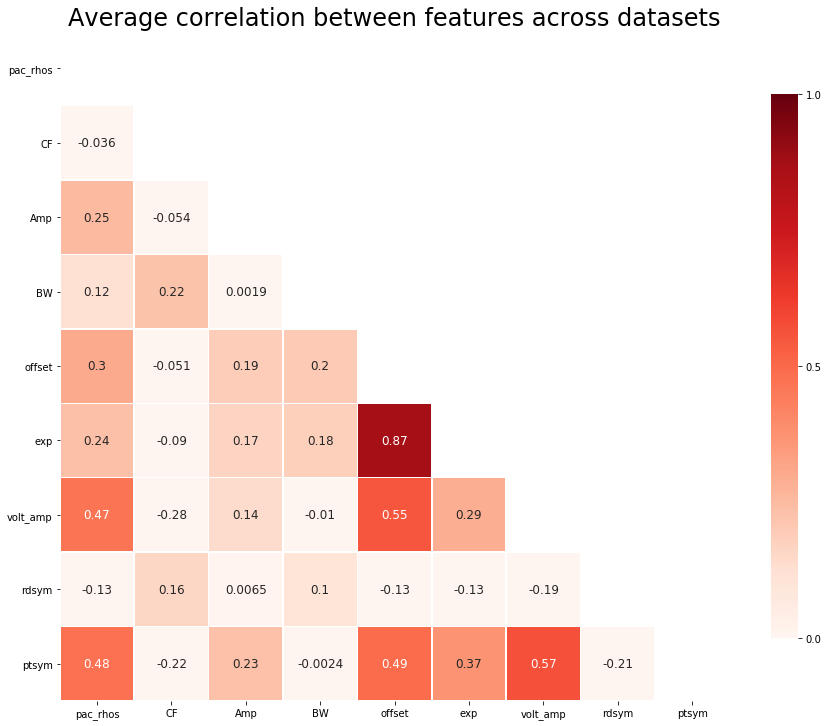

In [3]:
corr_mat_human = features_df['human'][['pac_rhos', 'CF', 'Amp', 'BW', 'offset', 'exp',
                                'volt_amp', 'rdsym', 'ptsym']].copy().corr()
corr_mat_monkey = features_df['monkey'][['pac_rhos', 'CF', 'Amp', 'BW', 'offset', 'exp',
                                'volt_amp', 'rdsym', 'ptsym']].copy().corr()
corr_mat_rat = features_df['rat'][['pac_rhos', 'CF', 'Amp', 'BW', 'offset', 'exp',
                                'volt_amp', 'rdsym', 'ptsym']].copy().corr()

corr_average = (corr_mat_human + corr_mat_monkey + corr_mat_rat) / 3

mask = np.zeros_like(corr_average, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(15, 20))

heatmap = sns.heatmap(corr_average,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'Reds',
                      cbar_kws = {'shrink': .5,
                                'ticks' : [0, 0.5, 1]},
                      vmin = 0,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})

#add the column names as labels
ax.set_yticklabels(corr_average.columns, rotation = 0)
ax.set_xticklabels(corr_average.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
plt.title('Average correlation between features across datasets', size=24)

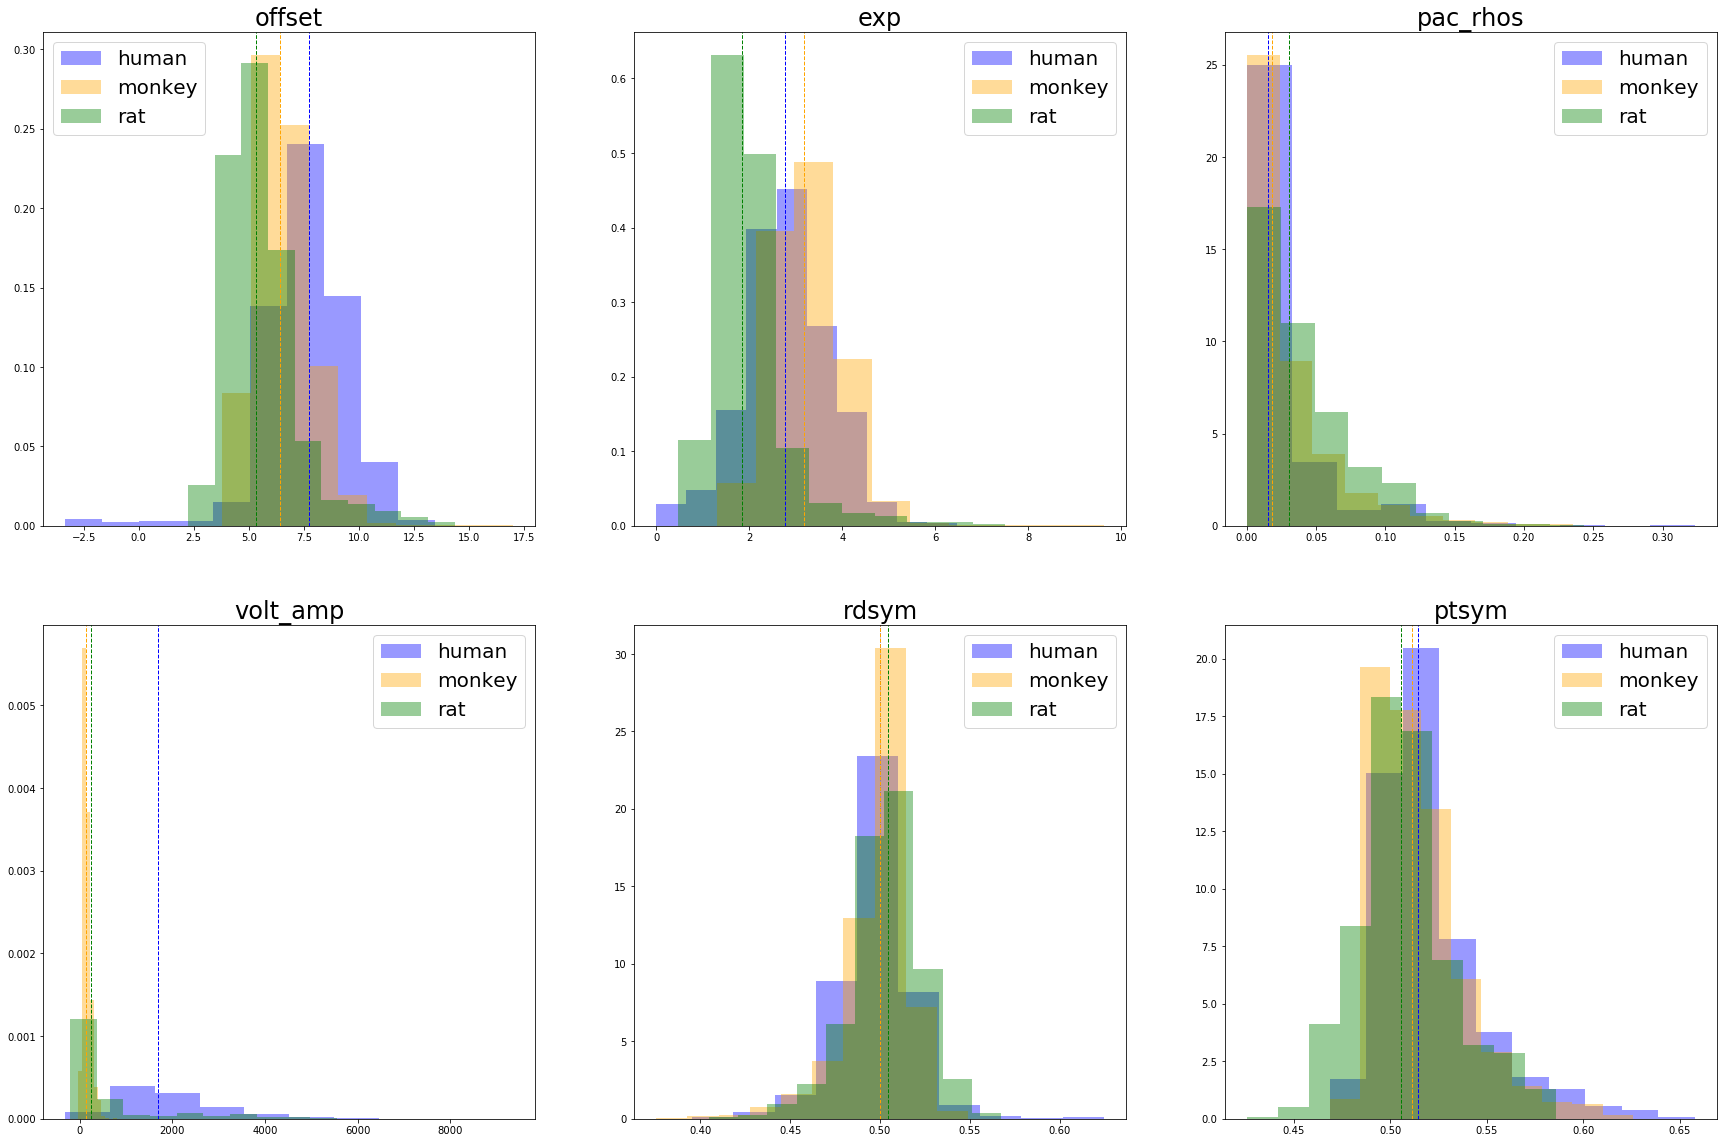

In [4]:
hist_list = ['offset', 'exp', 'pac_rhos', 
       'volt_amp', 'rdsym', 'ptsym']


kwargs = dict(histtype='stepfilled', alpha=0.4, density=True, bins=10)

plt.figure(figsize=(30,20))
for ii in range(len(hist_list)): 

    # subplots 4x3
    plt.subplot(2,3,ii+1)

    
    plt.hist(features_df['human'][hist_list[ii]].dropna(), color='blue', label='human', **kwargs)
    plt.hist(features_df['monkey'][hist_list[ii]].dropna(), color='orange', label='monkey', **kwargs)
    plt.hist(features_df['rat'][hist_list[ii]].dropna(), color='green', label='rat', **kwargs)

    
    plt.axvline(np.nanmedian(features_df['human'][hist_list[ii]]), color='blue', linestyle='dashed', linewidth=1)
    plt.axvline(np.nanmedian(features_df['monkey'][hist_list[ii]]), color='orange', linestyle='dashed', linewidth=1)
    plt.axvline(np.nanmedian(features_df['rat'][hist_list[ii]]), color='green', linestyle='dashed', linewidth=1)
    plt.legend(fontsize=20)
    plt.title(hist_list[ii], size=24)

# 3. Measured PAC 

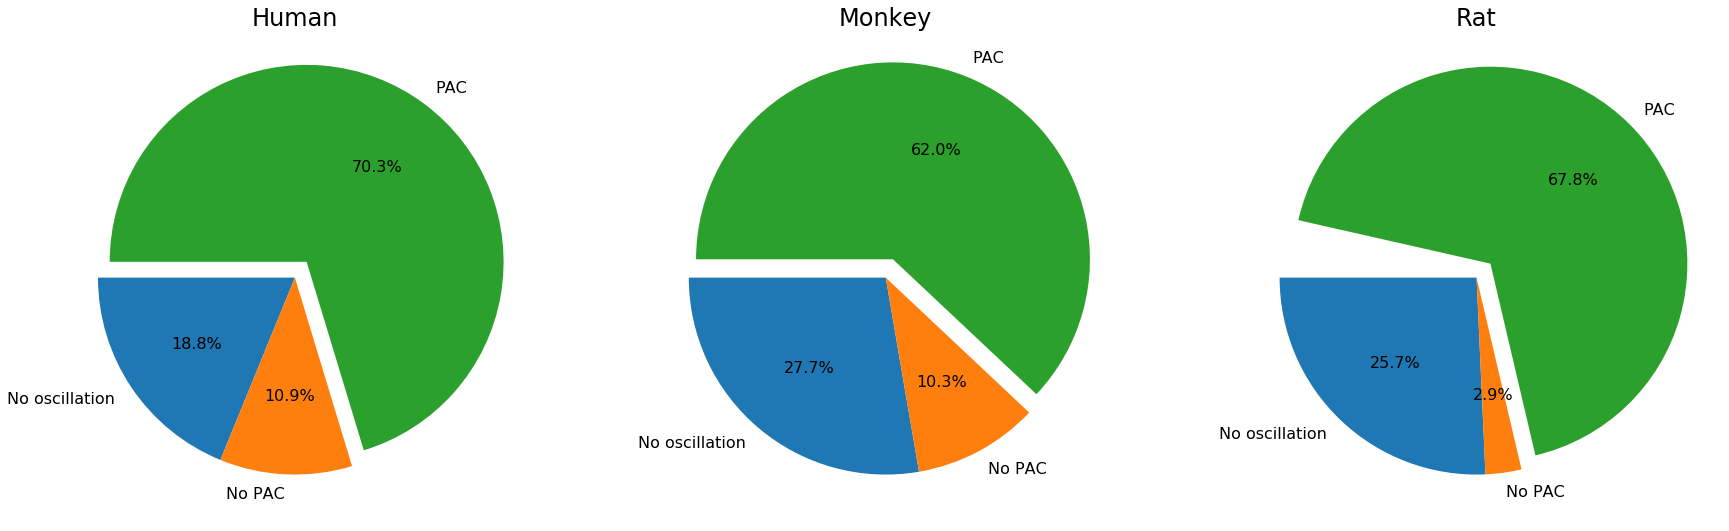

In [5]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'No oscillation', 'No PAC', 'PAC'
sizes = [[1 - (features_df['human']['CF'].count()/ len(features_df['human'])),
         len(features_df['human'][features_df['human']['pac_presence']==0]) / len(features_df['human']),
         len(features_df['human'][features_df['human']['pac_presence']==1]) / len(features_df['human'])],
         
         [1 - (features_df['monkey']['CF'].count()/ len(features_df['monkey'])),
         len(features_df['monkey'][features_df['monkey']['pac_presence']==0]) / len(features_df['monkey']),
         len(features_df['monkey'][features_df['monkey']['pac_presence']==1]) / len(features_df['monkey'])],

         [1 - (features_df['rat']['CF'].count()/ len(features_df['rat'])),
         len(features_df['rat'][features_df['rat']['pac_presence']==0]) / len(features_df['rat']),
         len(features_df['rat'][features_df['rat']['pac_presence']==1]) / len(features_df['rat'])]]
        
explode = (0, 0, 0.1)

titles = ['Human', 'Monkey', 'Rat']

plt.figure(figsize=(30,10))
for ii in range(len(sizes)): 

    # subplots 4x3
    plt.subplot(1,3,ii+1)
                
    plt.pie(sizes[ii], explode=explode, labels=labels, textprops={'size': 16}, autopct='%1.1f%%',
            shadow=False, startangle=180)
   # plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(titles[ii], size=24)

# 4. Machine learning - Distinguishing true and waveform shaped PAC

<Figure size 720x1440 with 0 Axes>

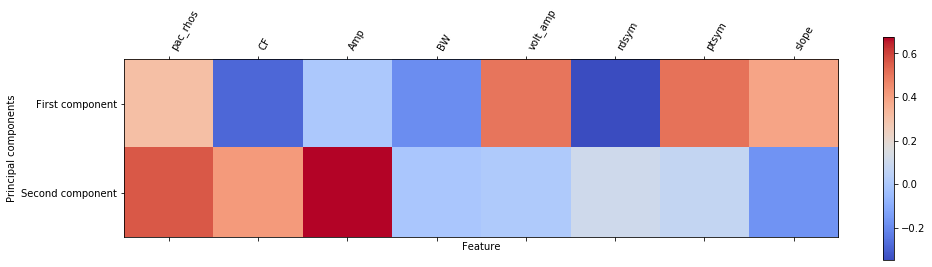

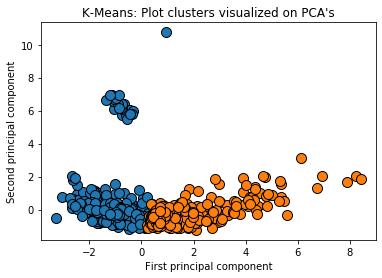

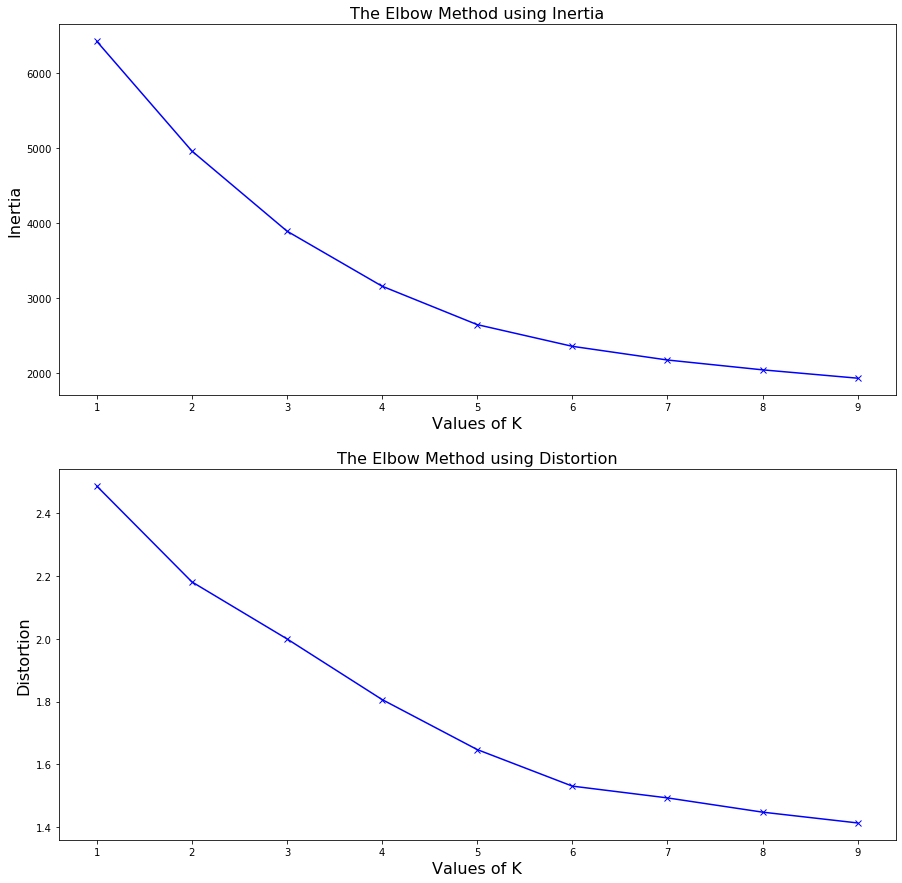

<Figure size 720x1440 with 0 Axes>

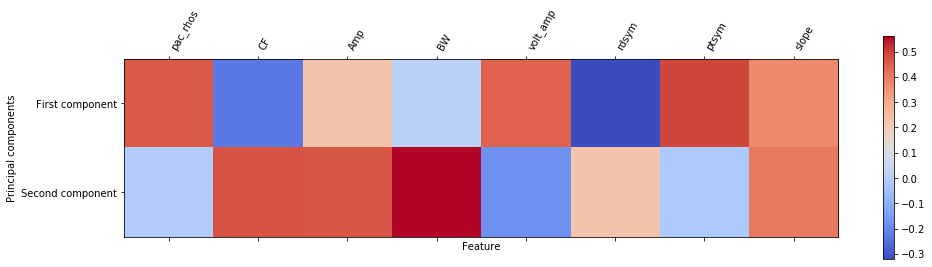

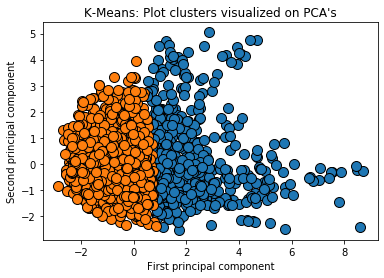

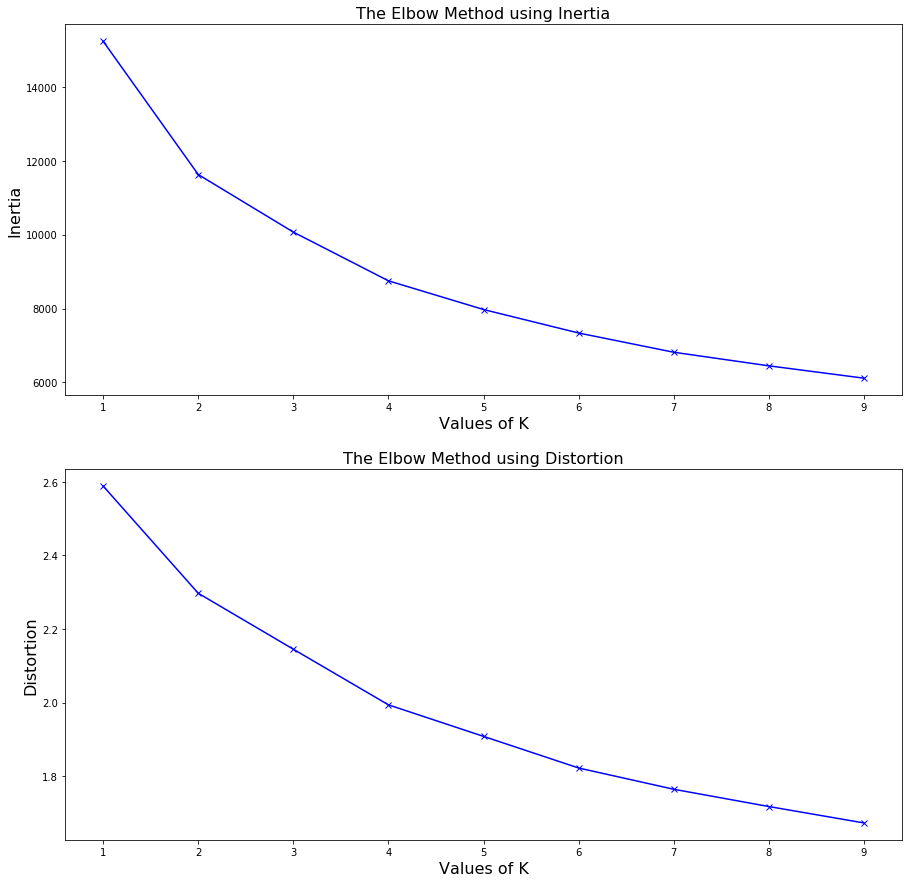

<Figure size 720x1440 with 0 Axes>

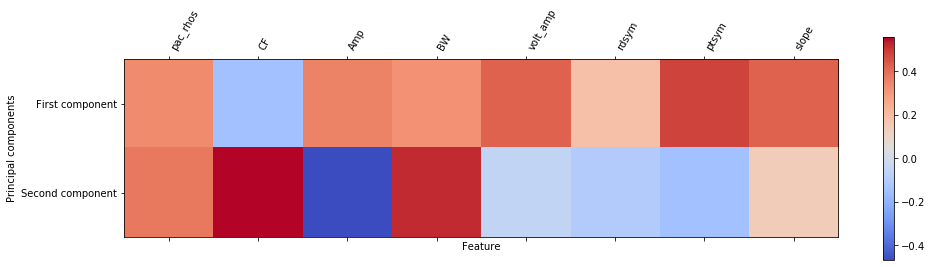

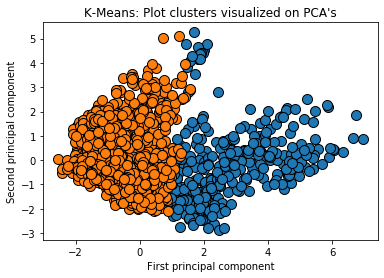

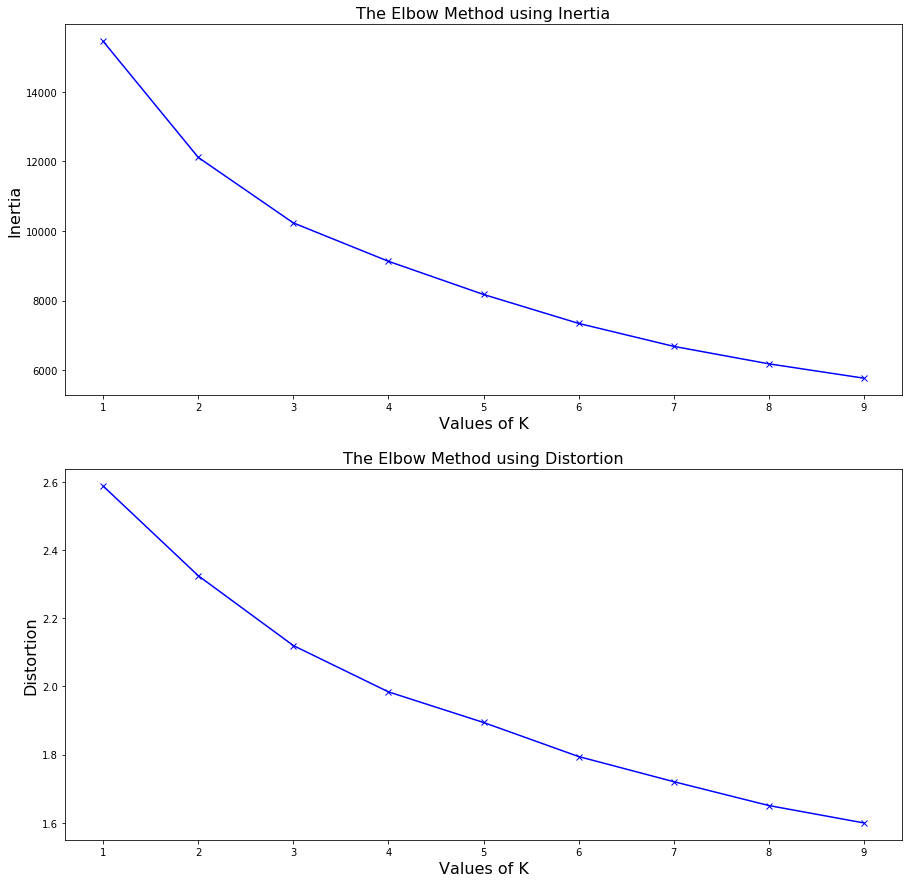

In [6]:
for key in datastruct:

    # change shape of the aperiodic slope measurement
    offset = np.reshape(features_df[key][['offset']].copy(), [len(features_df[key]['offset']), 1])
    exp = np.reshape(features_df[key][['exp']].copy(), [len(features_df[key]['exp']), 1])

    # standard scale into 1 variable
    scaler = StandardScaler()
    slope = scaler.fit_transform(offset) + scaler.fit_transform(exp)

    # write new feature to dataframe
    features_df[key]['slope'] = slope
    
    # get absolute assymetric measures by calculating distance from 0.5
    features_df[key]['rdsym_abs'] = abs(features_df[key]['rdsym'] -.5)
    features_df[key]['ptsym_abs'] = abs(features_df[key]['ptsym'] -.5)
    
    
    # then only select the channels that have sig. PAC after resampling
    features_df_pac = features_df[key][features_df[key]['pac_presence']==1]

    # stack the PAC values, periodic features, and the waveform shape features into 1 SKLearn shape
    cluster_features = np.hstack((
                       features_df_pac[['pac_rhos']].copy(), features_df_pac[['CF']].copy(), 
                       features_df_pac[['Amp']].copy(), features_df_pac[['BW']].copy(), 
                       features_df_pac[['volt_amp']].copy(), features_df_pac[['rdsym']].copy(), 
                       features_df_pac[['ptsym']].copy(), features_df_pac[['slope']].copy()))

    # Scale all data 
    scaler = StandardScaler()
    scaler.fit(cluster_features)
    X_scaled = scaler.transform(cluster_features)

    # Use K-Means to cluster into two groups
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(X_scaled);

    # Use PCA to create two components
    pca = PCA(n_components=2)
    pca.fit(X_scaled)
    X_pca = pca.transform(X_scaled)

    # Create list with feature names for visualization 
    feature_list = ['pac_rhos', 'CF', 'Amp', 'BW', 'volt_amp', 'rdsym', 'ptsym', 'slope' ]

    plt.figure(figsize=(10,20))


    # Which features drive both components?
    plt.matshow(pca.components_, cmap='coolwarm');
    plt.yticks([0, 1], ["First component", "Second component"]);
    plt.colorbar();
    plt.xticks(range(len(feature_list)),feature_list, rotation=60, ha='left');
    plt.xlabel("Feature");
    plt.ylabel("Principal components");
    plt.show()

    # visualize on PCA  
    mglearn.discrete_scatter(X_pca[:, 0], X_pca[:,1], kmeans.labels_, markers='o')
    plt.title('K-Means: Plot clusters visualized on PCA\'s')
    plt.xlabel("First principal component")
    plt.ylabel("Second principal component")
    plt.show()

    distortions = [] 
    inertias = [] 
    mapping1 = {} 
    mapping2 = {} 
    K = range(1,10) 

    for k in K: 
        #Building and fitting the model 
        kmeanModel = KMeans(n_clusters=k).fit(X_scaled) 
        kmeanModel.fit(X_scaled)     

        distortions.append(sum(np.min(cdist(X_scaled, kmeanModel.cluster_centers_, 
                          'euclidean'),axis=1)) / X_scaled.shape[0]) 
        inertias.append(kmeanModel.inertia_) 

        mapping1[k] = sum(np.min(cdist(X_scaled, kmeanModel.cluster_centers_, 
                     'euclidean'),axis=1)) / X_scaled.shape[0] 
        mapping2[k] = kmeanModel.inertia_ 

    plt.figure(figsize=(15,15))
    plt.subplot(2,1,1)
    plt.plot(K, inertias, 'bx-') 
    plt.xlabel('Values of K', size=16) 
    plt.ylabel('Inertia', size=16) 
    plt.title('The Elbow Method using Inertia', size=16) 

    plt.subplot(2,1,2)
    plt.plot(K, distortions, 'bx-') 
    plt.xlabel('Values of K', size=16) 
    plt.ylabel('Distortion', size=16) 
    plt.title('The Elbow Method using Distortion', size=16) 
    plt.show()

# 5. Linear regressions - Effect of features on Rho Value

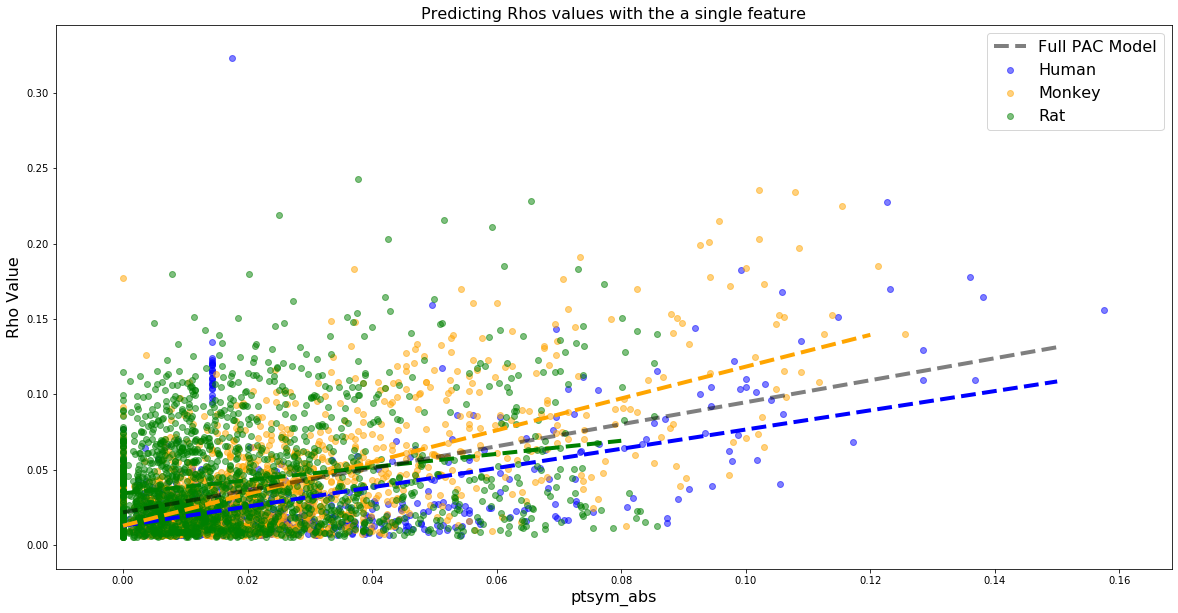

Human R^2: 0.544
Human pval: 0.0
Monkey R^2: 0.704
Monkey pval: 0.0
Rat R^2: 0.444
Rat pval: 0.0
Total R^2: 0.444
Total pval: 0.0


Human R^2: 0.318
Human pval: 0.0
Monkey R^2: 0.479
Monkey pval: 0.0
Rat R^2: 0.314
Rat pval: 0.0
Total R^2: 0.314
Total pval: 0.0


C:\Users\jaapv\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


Human R^2: 0.565
Human pval: 0.0
Monkey R^2: 0.728
Monkey pval: 0.0
Rat R^2: 0.287
Rat pval: 0.0
Total R^2: 0.287
Total pval: 0.0


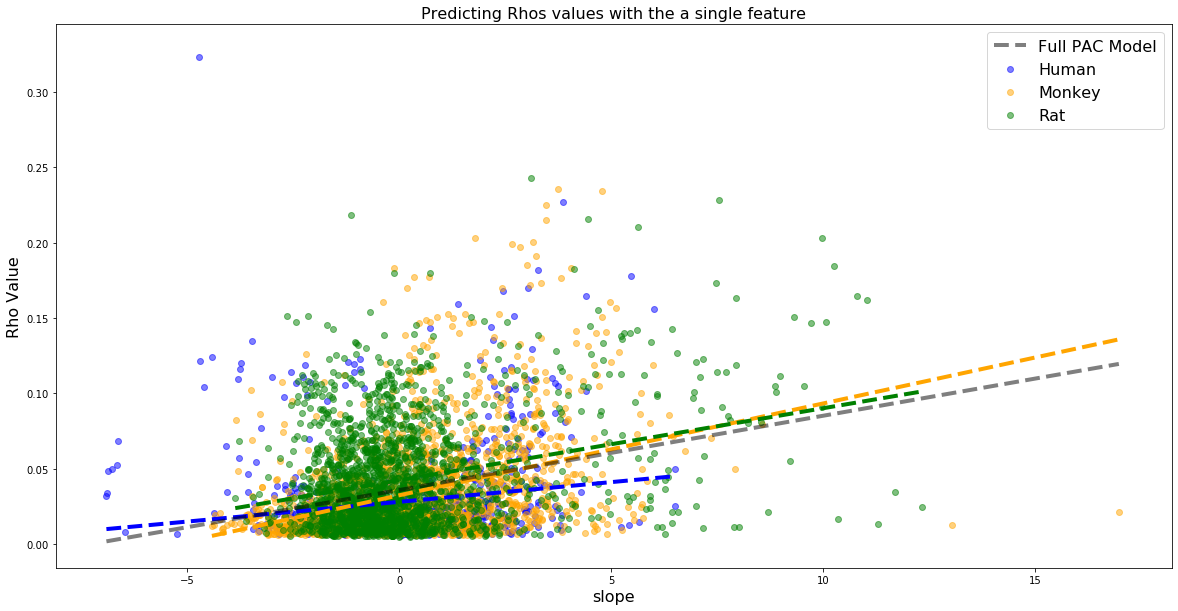

Human R^2: 0.02
Human pval: 0.0
Monkey R^2: 0.125
Monkey pval: 0.0
Rat R^2: 0.041
Rat pval: 0.0
Total R^2: 0.041
Total pval: 0.0


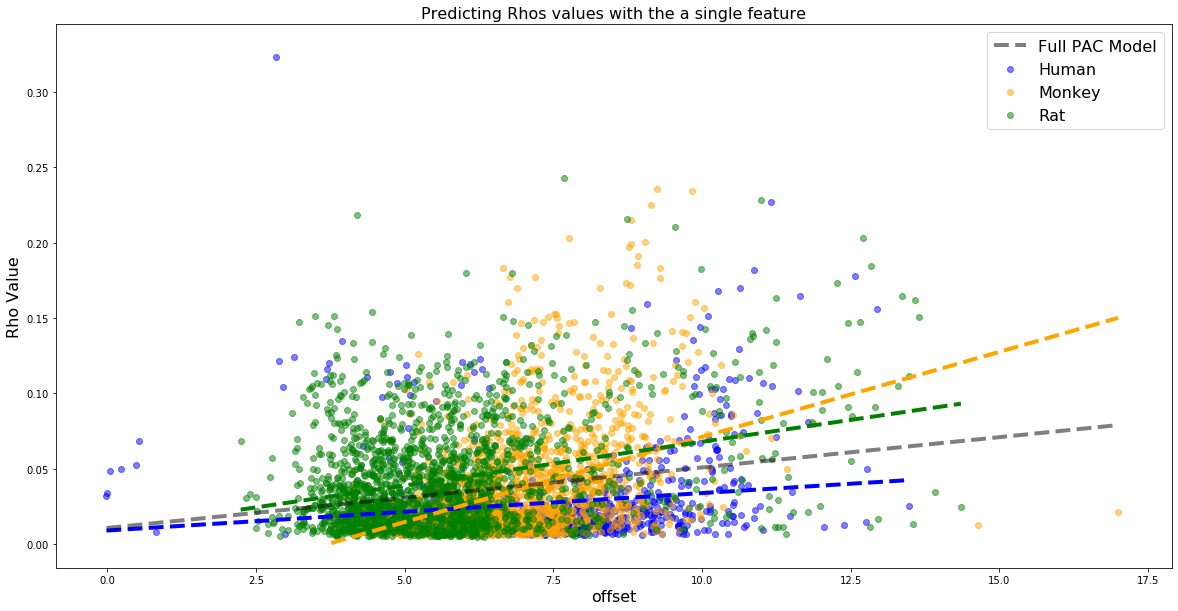

Human R^2: 0.449
Human pval: 0.0
Monkey R^2: 0.583
Monkey pval: 0.0
Rat R^2: 0.636
Rat pval: 0.0
Total R^2: 0.636
Total pval: 0.0


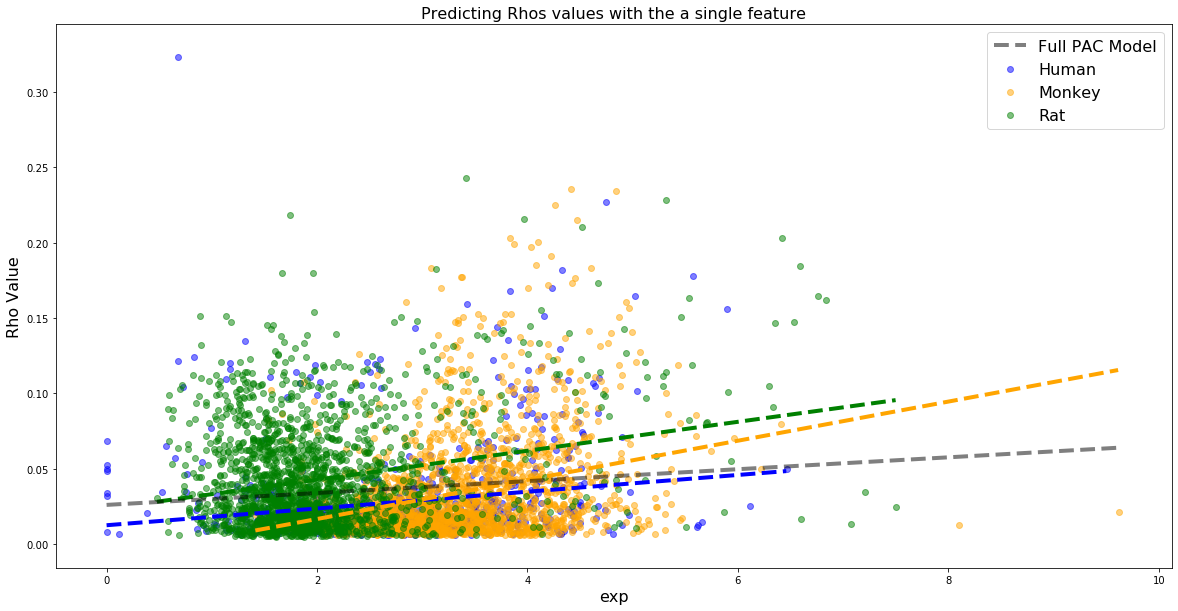

Human R^2: 0.447
Human pval: 0.0
Monkey R^2: 0.558
Monkey pval: 0.0
Rat R^2: 0.598
Rat pval: 0.0
Total R^2: 0.598
Total pval: 0.0


In [7]:
# reshape pac_rhos
pac_rhos_human = features_df['human'][features_df['human']['pac_presence']==1]['pac_rhos'].values.reshape(-1,1)
pac_rhos_monkey = features_df['monkey'][features_df['monkey']['pac_presence']==1]['pac_rhos'].values.reshape(-1,1)
pac_rhos_rat = features_df['rat'][features_df['rat']['pac_presence']==1]['pac_rhos'].values.reshape(-1,1)


"""
The features/columns: 

['subj', 'day', 'ch', 'ep', 'CF', 'Amp', 'BW', 'offset', 'knee', 'exp',
       'LG_CF', 'LG_Amp', 'LG_BW', 'pac_presence', 'pac_pvals', 'pac_rhos',
       'LG_pac_presence', 'LG_pac_pvals', 'LG_pac_rhos', 'volt_amp', 'rdsym',
       'ptsym', 'slope', 'ptsym_abs', 'rdsym_abs']
"""

feature = ['ptsym_abs', 'rdsym_abs', 'volt_amp','slope','offset', 'exp']

for ii in range(len(feature)):

    # reshape other feature
    feature_human = features_df['human'][features_df['human']['pac_presence']==1][feature[ii]].values.reshape(-1,1)
    feature_monkey = features_df['monkey'][features_df['monkey']['pac_presence']==1][feature[ii]].values.reshape(-1,1)
    feature_rat = features_df['rat'][features_df['rat']['pac_presence']==1][feature[ii]].values.reshape(-1,1)

    plt.figure(figsize=(20,10))

    # Human scatter
    plt.scatter(features_df['human'][features_df['human']['pac_presence']==1][feature[ii]],
                features_df['human'][features_df['human']['pac_presence']==1]['pac_rhos'],
               color='blue', alpha =.5, label='Human')

    # Monkey scatter
    plt.scatter(features_df['monkey'][features_df['monkey']['pac_presence']==1][feature[ii]],
                features_df['monkey'][features_df['monkey']['pac_presence']==1]['pac_rhos'],
               color='orange', alpha =.5, label='Monkey')

    # Rat scatter
    plt.scatter(features_df['rat'][features_df['rat']['pac_presence']==1][feature[ii]],
                features_df['rat'][features_df['rat']['pac_presence']==1]['pac_rhos'],
               color='green', alpha =.5, label='Rat')


    # Human regression
    reg1 = linear_model.LinearRegression()
    reg1.fit(feature_human, pac_rhos_human)
    xs = np.arange(min(feature_human), max(feature_human),0.01)
    ys = reg1.intercept_[0] + reg1.coef_[0][0] * xs
    plt.plot(xs, ys, '--', color='blue', linewidth=4, alpha=1)

    # Monkey regression
    reg2 = linear_model.LinearRegression()
    reg2.fit(feature_monkey, pac_rhos_monkey)
    xs = np.arange(min(feature_monkey), max(feature_monkey),0.01)
    ys = reg2.intercept_[0] + reg2.coef_[0][0] * xs
    plt.plot(xs, ys, '--', color='orange', linewidth=4, alpha=1)

    # Rat regression
    reg3 = linear_model.LinearRegression()
    reg3.fit(feature_rat, pac_rhos_rat)
    xs = np.arange(min(feature_rat), max(feature_rat),0.01)
    ys = reg3.intercept_[0] + reg3.coef_[0][0] * xs
    plt.plot(xs, ys, '--', color='green', linewidth=4, alpha=1)

    # Regression model on all combined
    # concatenate the three groups and reshape
    pac_rhos_comb = np.reshape(np.concatenate((pac_rhos_human, pac_rhos_monkey, pac_rhos_rat), axis=None), [-1, 1])
    feature_comb = np.reshape(np.concatenate((feature_human, feature_monkey, feature_rat), axis=None), [-1, 1])

    # regression combo
    reg4= linear_model.LinearRegression()
    reg4.fit(feature_comb, pac_rhos_comb)
    xs = np.arange(min(feature_comb), max(feature_comb),0.01)
    ys = reg4.intercept_[0] + reg4.coef_[0][0] * xs
    plt.plot(xs, ys, '--', color='black', linewidth=4, label='Full PAC Model', alpha=.5)

    # 
    plt.title('Predicting Rhos values with the a single feature', fontsize=16)
    plt.xlabel(feature[ii], fontsize=16)
    plt.ylabel('Rho Value', fontsize=16)
    plt.legend(fontsize=16)
    plt.show()
    
    reg_human = OLS(pac_rhos_human, feature_human).fit()
    reg_monkey = OLS(pac_rhos_monkey, feature_monkey).fit()
    reg_rat = OLS(pac_rhos_rat, feature_rat).fit()
    reg_total = OLS(pac_rhos_comb, feature_comb).fit()

    print('Human R^2: ' +  str(round(reg_human.rsquared,3)))
    print('Human pval: ' +  str(round(reg_human.pvalues[0],3)))

    print('Monkey R^2: ' +  str(round(reg_monkey.rsquared,3)))
    print('Monkey pval: ' +  str(round(reg_monkey.pvalues[0],3)))

    print('Rat R^2: ' +  str(round(reg_rat.rsquared,3)))
    print('Rat pval: ' +  str(round(reg_rat.pvalues[0],3)))
    
    print('Total R^2: ' +  str(round(reg_rat.rsquared,3)))
    print('Total pval: ' +  str(round(reg_rat.pvalues[0],3)))   


# 6. Investigating short timeseries with strong oscillations - compare distribution of PT symmetry in bursts to the full channel 

In [8]:
os.chdir(r'C:\Users\jaapv\Desktop\master\VoytekLab')
burst_list = np.load('burst_list_dict.npy',  allow_pickle=True).item()

# first we want to get the Rho values of PAC of the burst to compare those to the full channel PAC values

# set range of the band 
amplitude_providing_band = [80, 250]

burst_rhos_dict = {}

for key in datastruct: 
    
    burst_rhos = [np.nan] * len(burst_list[key])
    
    for ii in range(len(burst_list[key])):

        if type(burst_list[key][ii]) == list:

            if burst_list[key][ii][2]:

                # define phase providing band
                CF = features_df[key]['CF'][ii]
                BW = features_df[key]['BW'][ii]


                # phase_providing_band= [(CF - (BW/2)),  (CF + (BW/2))]
                phase_providing_band= [(CF - (BW/2))-1,  (CF + (BW/2))+1]

                start_sample = burst_list[key][ii][0]
                end_sample = burst_list[key][ii][1]

                signal, fs = get_signal(datastruct, features_df, key, ii) 
                signal = signal[start_sample:end_sample]


                # use butter bandpass filter to extract this frequency range
                phase_data = pacf.butter_bandpass_filter(signal, phase_providing_band[0], phase_providing_band[1], fs);
                phase_data_hilbert = hilbert(phase_data);
                phase_data_angle = np.angle(phase_data_hilbert);

                # use butter bandpass filter to extract this frequency range
                amp_data = pacf.butter_bandpass_filter(signal, amplitude_providing_band[0], amplitude_providing_band[1], fs);
                amp_data_hilbert = hilbert(amp_data);
                amp_data_abs = abs(amp_data_hilbert);            

                #calculate circle correlation
                rho, pval, r_2, standard_error = pacf.circle_corr(phase_data_angle, amp_data_abs)

                burst_rhos[ii] = rho

    burst_rhos_dict[key] = burst_rhos

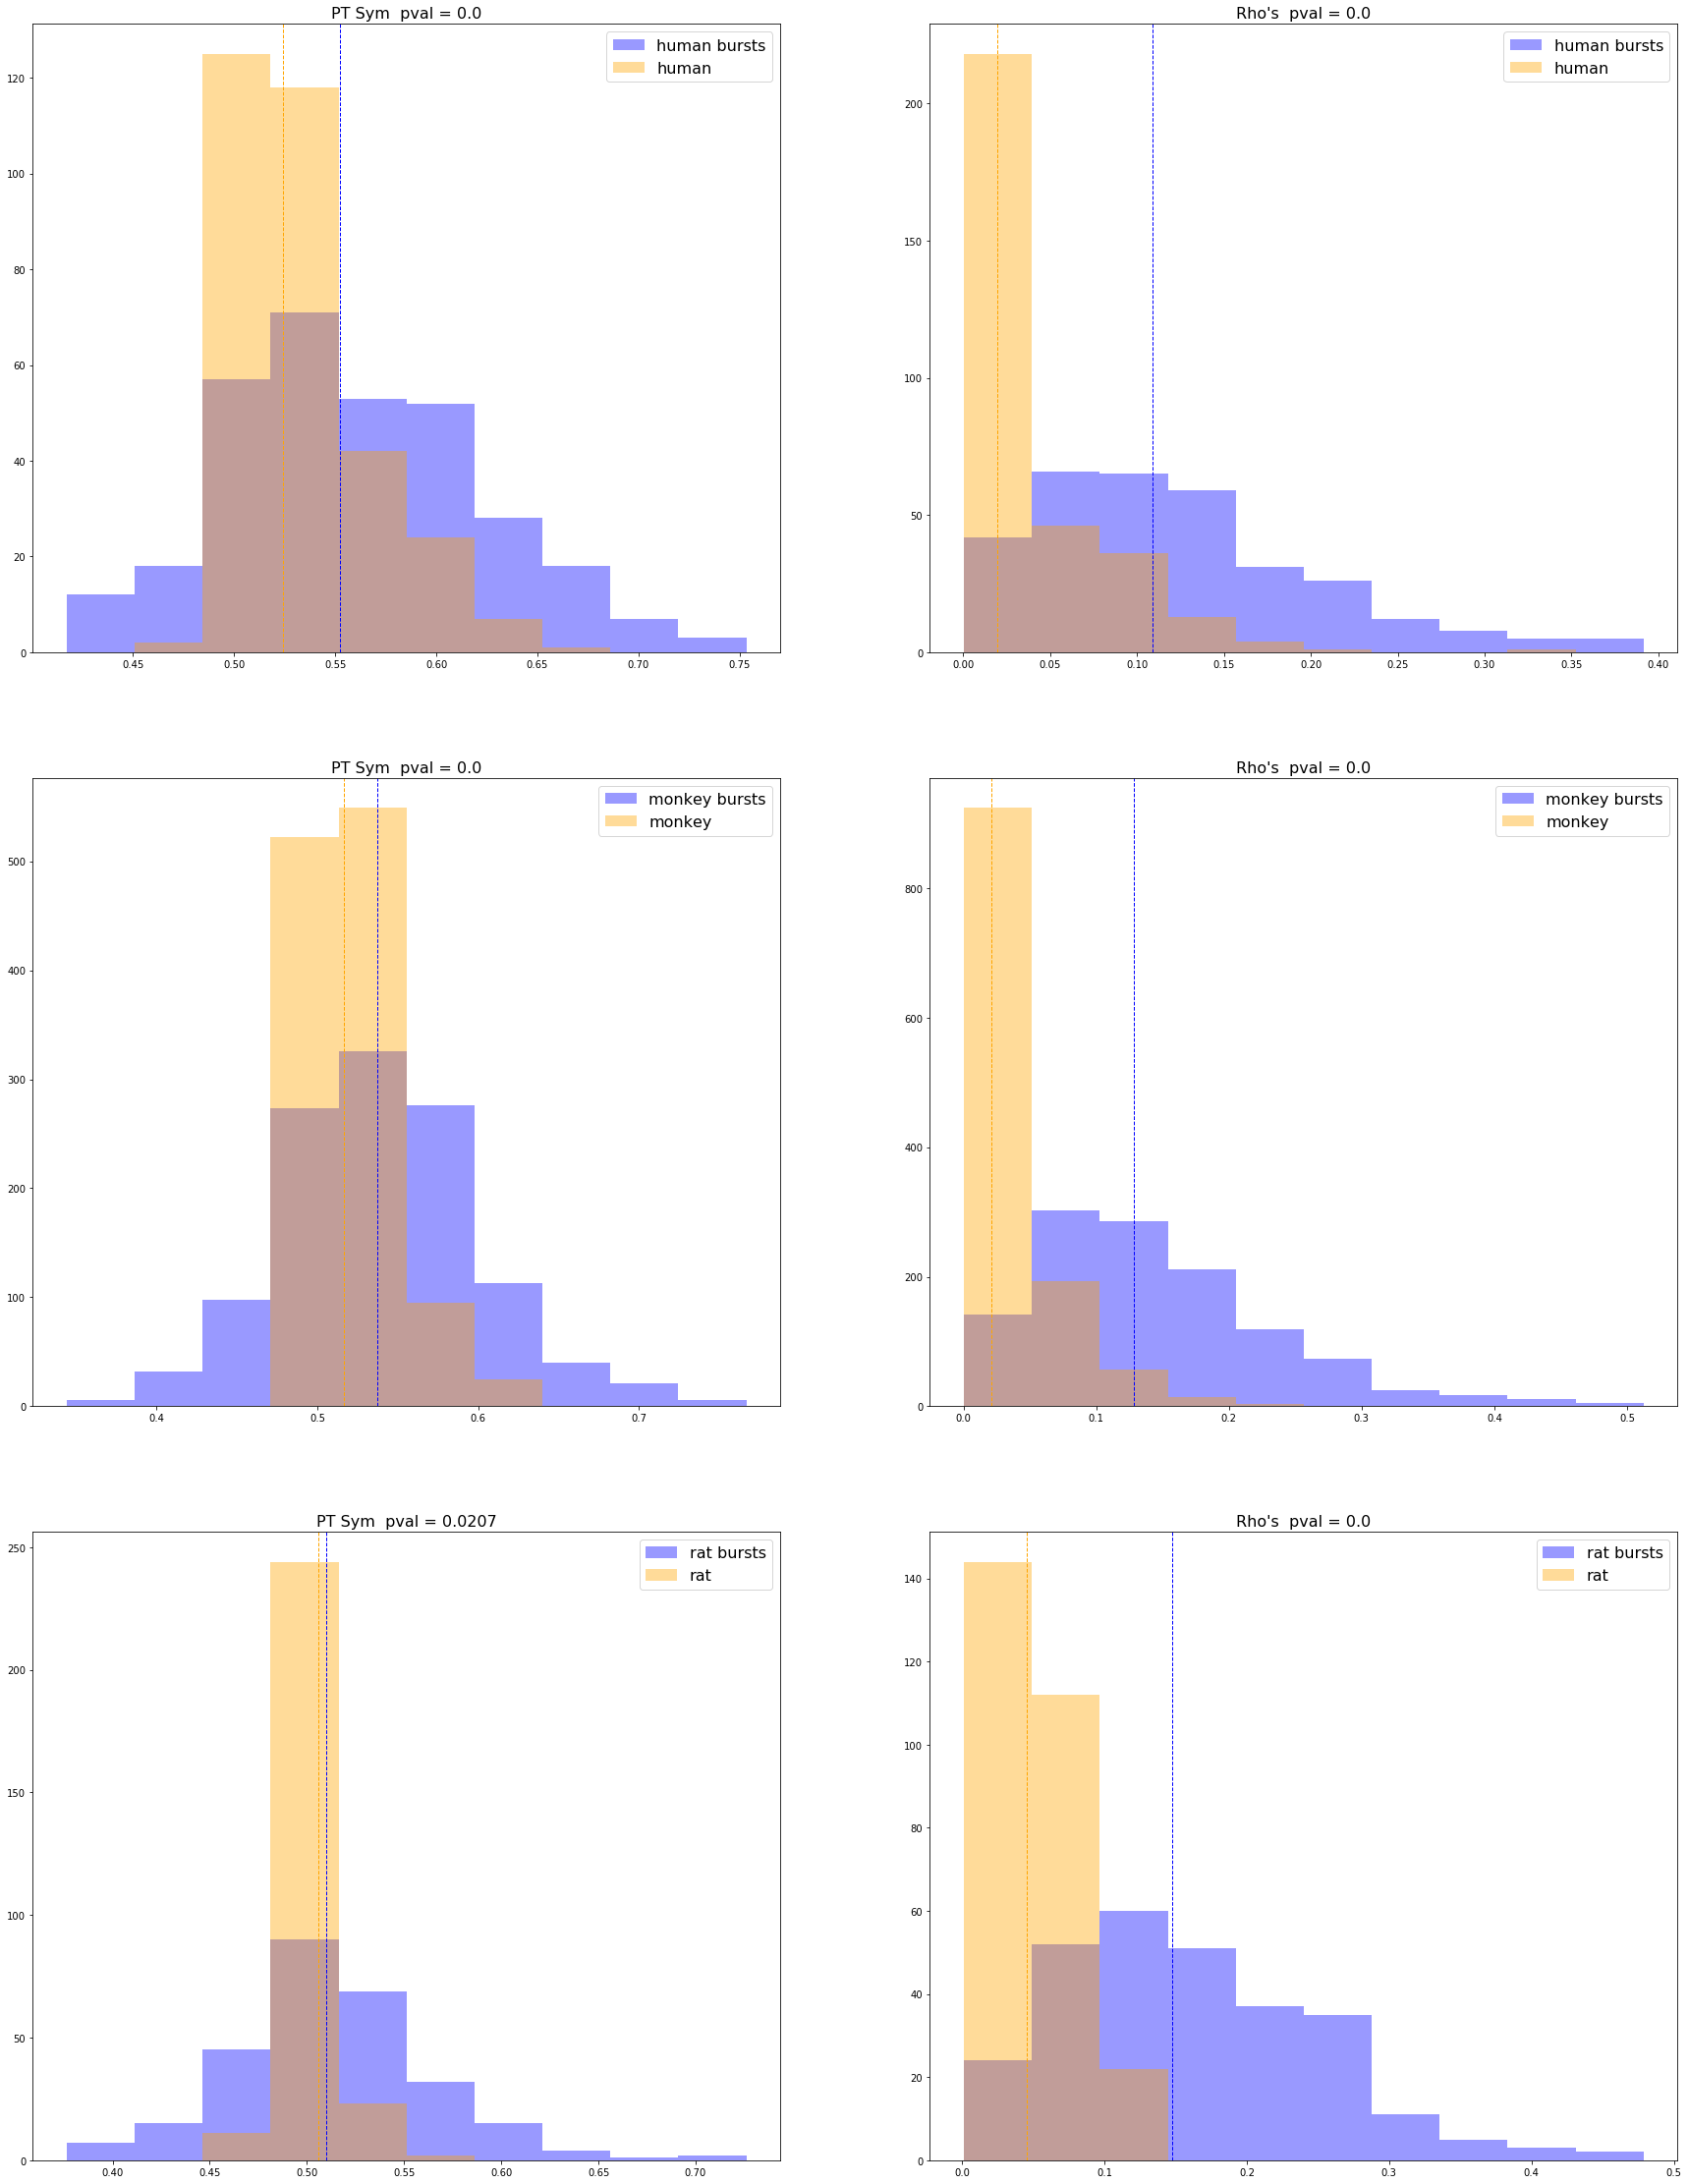

In [9]:
# get only the channels with a burst for comparing with their full channel distribution
burst_chs = {}
for key in datastruct: 

    burst_chs[key] = [ii 
                      for ii in range(len(burst_list[key])) 
                      if type(burst_list[key][ii]) == list 
                      if burst_list[key][ii][2]]



plt.figure(figsize=(30,40))
kwargs = dict(alpha=0.4)
jj = 0

for key in datastruct: 
        
    # pt symmetry
    jj = jj + 1
    plt.subplot(3,2,jj)

    burst_ptsym = [np.median(burst_list[key][ii][4]) 
              for ii in range(len(burst_list[key])) 
              if type(burst_list[key][ii]) == list
              if burst_list[key][ii][4]]

    burst_ptsym_fullch = [features_df[key]['ptsym'][burst_chs[key][ii]]
                     for ii in range(len(burst_chs[key]))]
        
    bins=np.histogram(np.hstack((burst_ptsym,burst_ptsym_fullch)), bins=10)[1]
    
    plt.hist(burst_ptsym, color='blue', bins=bins, label=(key + ' bursts'), **kwargs)
    plt.hist(burst_ptsym_fullch, color='orange', bins=bins, label=key, **kwargs)
    plt.axvline(np.nanmedian(burst_ptsym), color='blue', linestyle='dashed', linewidth=1)
    plt.axvline(np.nanmedian(burst_ptsym_fullch), color='orange', linestyle='dashed', linewidth=1)

    Uval, pval = stats.mannwhitneyu(burst_ptsym, 
                                 burst_ptsym_fullch, 
                                 use_continuity=True, alternative=None)

    plt.title('PT Sym  ' + 'pval = ' + str(round(pval,4)), size=16)
    plt.legend(fontsize=16)
    
    # Rho values 
    jj = jj + 1
    plt.subplot(3,2,jj)
        
    burst_rhos = [burst_rhos_dict[key][ii] 
                  for ii in range(len(burst_rhos_dict[key])) 
                  if str(burst_rhos_dict[key][ii]) != 'nan']
    
    burst_rhos_fullch = [features_df[key]['pac_rhos'][burst_chs[key][ii]]
                         for ii in range(len(burst_chs[key]))
                         if str(features_df[key]['pac_rhos'][burst_chs[key][ii]]) != 'nan']
 
    bins=np.histogram(np.hstack((burst_rhos,burst_rhos_fullch)), bins=10)[1]

    plt.hist(burst_rhos, color='blue', bins=bins, label=(key + ' bursts'), **kwargs)
    plt.hist(burst_rhos_fullch, color='orange', bins=bins, label=key, **kwargs)
    plt.axvline(np.nanmedian(burst_rhos), color='blue', linestyle='dashed', linewidth=1)
    plt.axvline(np.nanmedian(burst_rhos_fullch), color='orange', linestyle='dashed', linewidth=1)
    
    Uval, pval = stats.mannwhitneyu(burst_rhos, 
                                 burst_rhos_fullch, 
                                 use_continuity=True, alternative=None)
    
    plt.title('Rho\'s  ' + 'pval = ' + str(round(pval,4)), size=16)
    plt.legend(fontsize=16)

# 7. Low Gamma PAC descriptives

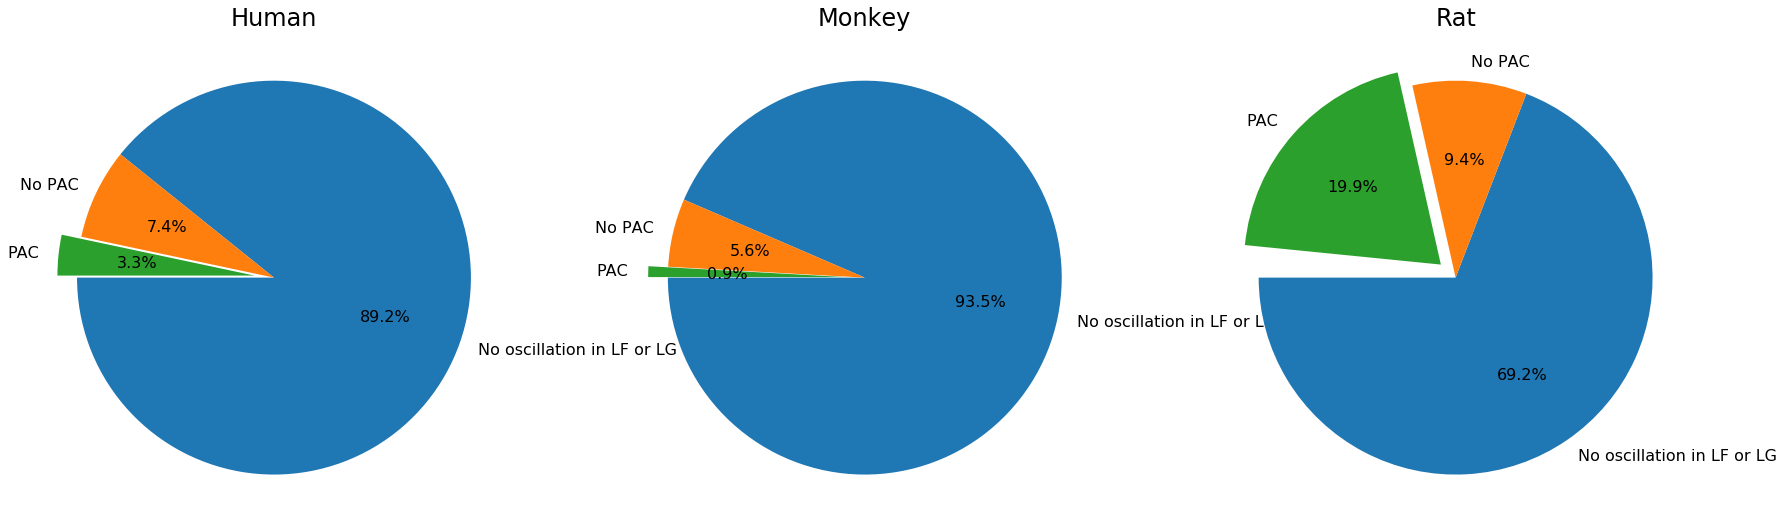

In [10]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'No oscillation in LF or LG', 'No PAC', 'PAC'
sizes = [[1 - (len(features_df['human'][(~np.isnan(features_df['human']['CF'])) &
                                         (~np.isnan(features_df['human']['LG_CF']))]) / len(features_df['human'])),
         len(features_df['human'][features_df['human']['LG_pac_presence']==0]) / len(features_df['human']),
         len(features_df['human'][features_df['human']['LG_pac_presence']==1]) / len(features_df['human'])],
         
         [1 - (len(features_df['monkey'][(~np.isnan(features_df['monkey']['CF'])) &
                                         (~np.isnan(features_df['monkey']['LG_CF']))]) / len(features_df['monkey'])),
         len(features_df['monkey'][features_df['monkey']['LG_pac_presence']==0]) / len(features_df['monkey']),
         len(features_df['monkey'][features_df['monkey']['LG_pac_presence']==1]) / len(features_df['monkey'])],

         [1 - (len(features_df['rat'][(~np.isnan(features_df['rat']['CF'])) &
                                      (~np.isnan(features_df['rat']['LG_CF']))]) / len(features_df['rat'])),
         len(features_df['rat'][features_df['rat']['LG_pac_presence']==0]) / len(features_df['rat']),
         len(features_df['rat'][features_df['rat']['LG_pac_presence']==1]) / len(features_df['rat'])]]
        
explode = (0, 0, 0.1)

titles = ['Human', 'Monkey', 'Rat']

plt.figure(figsize=(30,10))
for ii in range(len(sizes)): 

    # subplots 4x3
    plt.subplot(1,3,ii+1)
                
    plt.pie(sizes[ii], explode=explode, labels=labels, textprops={'size': 16}, autopct='%1.1f%%',
            shadow=False, startangle=180)
   # plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(titles[ii], size=24)

# 8. Differences between LG and HG PAC in predicting Rho value 

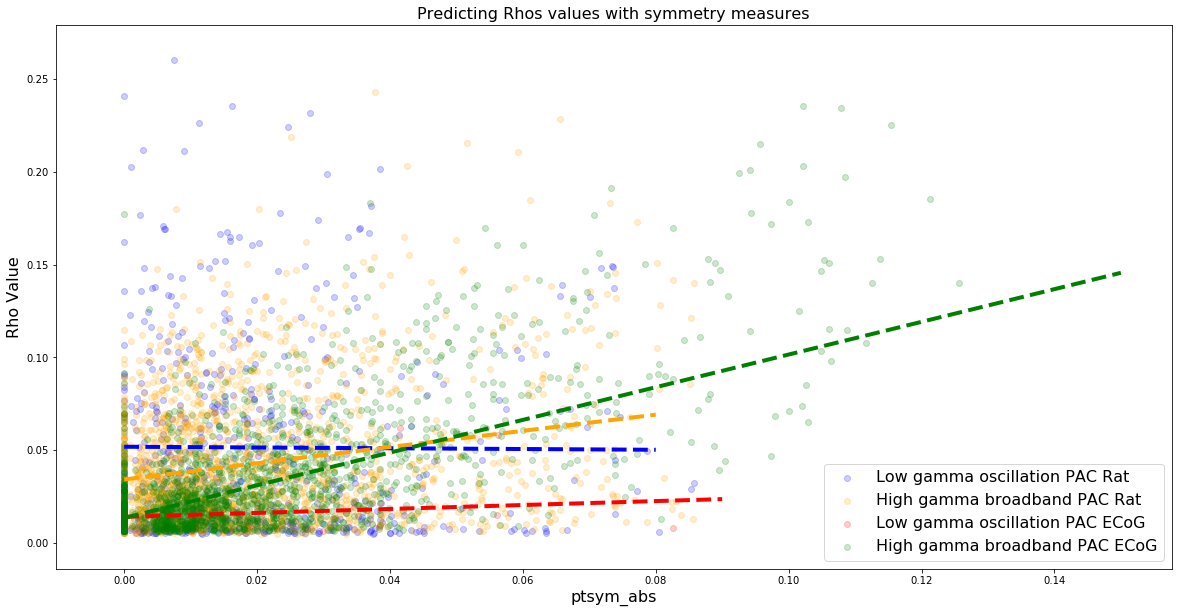

LG rat R^2: 0.284
LG rat pval: 0.0
HG rat R^2: 0.444
HG rat pval: 0.0
LG ECoG R^2: 0.447
LG ECoG pval: 0.0
HG ECoG R^2: 0.64
HG ECoG pval: 0.0


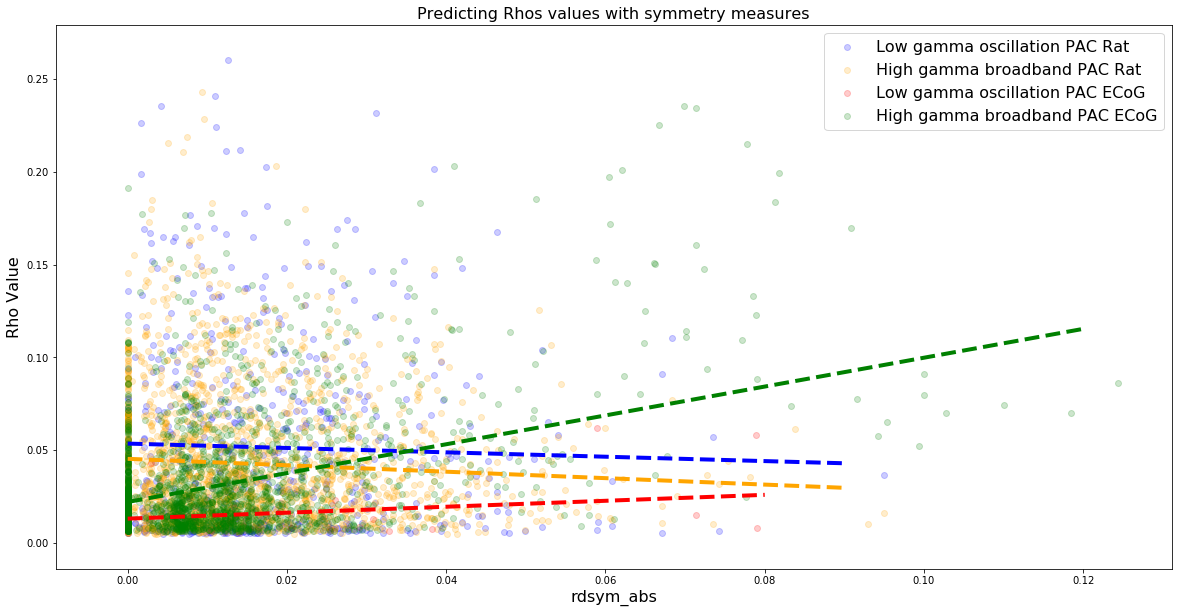

LG rat R^2: 0.305
LG rat pval: 0.0
HG rat R^2: 0.314
HG rat pval: 0.0
LG ECoG R^2: 0.469
LG ECoG pval: 0.0
HG ECoG R^2: 0.427
HG ECoG pval: 0.0


C:\Users\jaapv\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


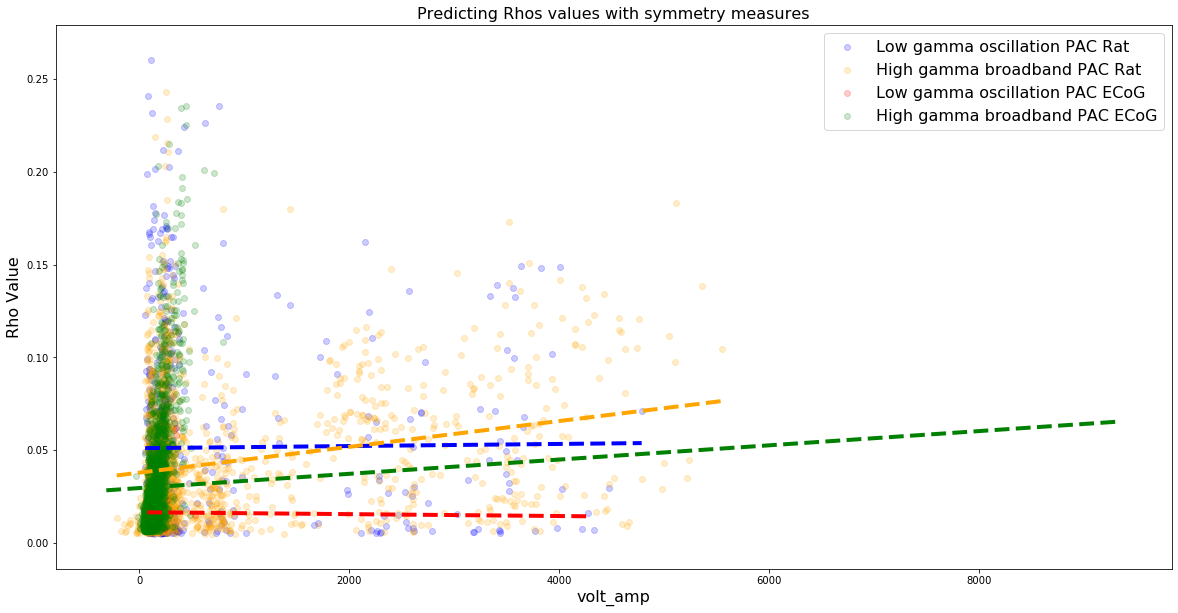

LG rat R^2: 0.158
LG rat pval: 0.0
HG rat R^2: 0.287
HG rat pval: 0.0
LG ECoG R^2: 0.368
LG ECoG pval: 0.0
HG ECoG R^2: 0.212
HG ECoG pval: 0.0


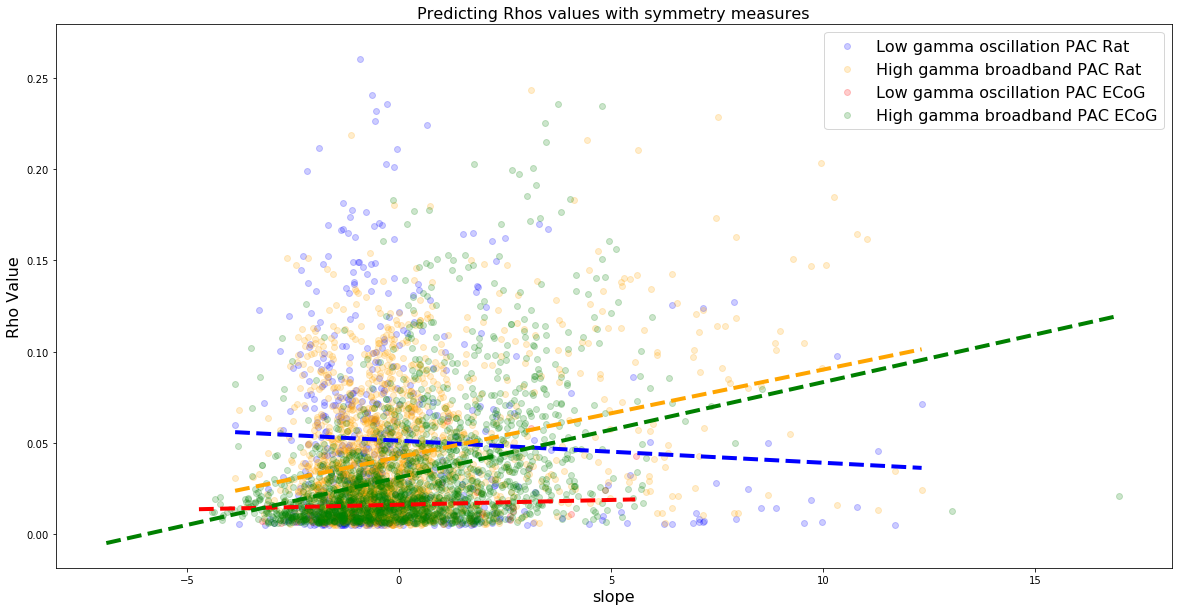

LG rat R^2: 0.005
LG rat pval: 0.091
HG rat R^2: 0.041
HG rat pval: 0.0
LG ECoG R^2: 0.018
LG ECoG pval: 0.287
HG ECoG R^2: 0.089
HG ECoG pval: 0.0


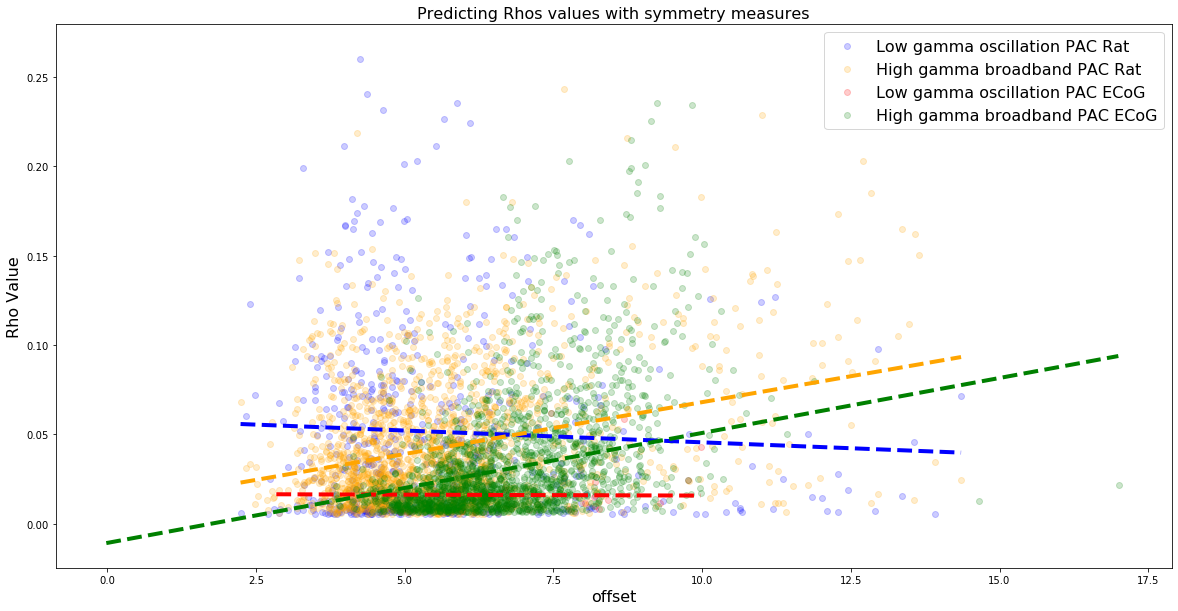

LG rat R^2: 0.43
LG rat pval: 0.0
HG rat R^2: 0.636
HG rat pval: 0.0
LG ECoG R^2: 0.633
LG ECoG pval: 0.0
HG ECoG R^2: 0.533
HG ECoG pval: 0.0


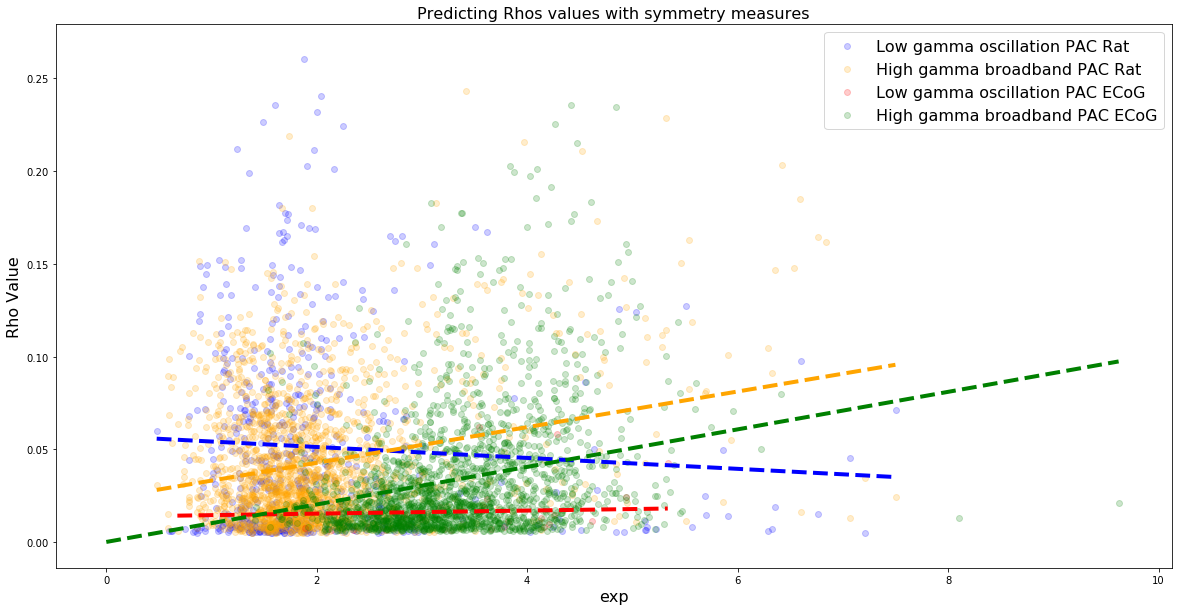

LG rat R^2: 0.369
LG rat pval: 0.0
HG rat R^2: 0.598
HG rat pval: 0.0
LG ECoG R^2: 0.619
LG ECoG pval: 0.0
HG ECoG R^2: 0.529
HG ECoG pval: 0.0


In [11]:
# reshape pac_rhos
LG_pac_rhos_rat = features_df['rat'][features_df['rat']['LG_pac_presence']==1]['LG_pac_rhos'].values.reshape(-1,1)
HG_pac_rhos_rat = features_df['rat'][features_df['rat']['pac_presence']==1]['pac_rhos'].values.reshape(-1,1)

LG_pac_rhos_ecog = np.append(features_df['monkey'][features_df['monkey']['LG_pac_presence']==1]['LG_pac_rhos'].values, 
         features_df['human'][features_df['human']['LG_pac_presence']==1]['LG_pac_rhos'].values).reshape(-1,1)
HG_pac_rhos_ecog = np.append(features_df['monkey'][features_df['monkey']['pac_presence']==1]['pac_rhos'].values, 
         features_df['human'][features_df['human']['pac_presence']==1]['pac_rhos'].values).reshape(-1,1)


"""
The features/columns: 

['subj', 'day', 'ch', 'ep', 'CF', 'Amp', 'BW', 'offset', 'knee', 'exp',
       'LG_CF', 'LG_Amp', 'LG_BW', 'pac_presence', 'pac_pvals', 'pac_rhos',
       'LG_pac_presence', 'LG_pac_pvals', 'LG_pac_rhos', 'volt_amp', 'rdsym',
       'ptsym', 'slope', 'ptsym_abs', 'rdsym_abs']
"""

feature = ['ptsym_abs', 'rdsym_abs', 'volt_amp','slope','offset', 'exp']

for ii in range(len(feature)):
    
    # reshape other feature
    LG_feature_rat = features_df['rat'][features_df['rat']['LG_pac_presence']==1][feature[ii]].values.reshape(-1,1)
    HG_feature_rat = features_df['rat'][features_df['rat']['pac_presence']==1][feature[ii]].values.reshape(-1,1)

    LG_feature_ecog = np.append(features_df['monkey'][features_df['monkey']['LG_pac_presence']==1][feature[ii]].values,
                                  features_df['human'][features_df['human']['LG_pac_presence']==1][feature[ii]].values).reshape(-1,1)

    HG_feature_ecog = np.append(features_df['monkey'][features_df['monkey']['pac_presence']==1][feature[ii]].values,
                                  features_df['human'][features_df['human']['pac_presence']==1][feature[ii]].values).reshape(-1,1)

    plt.figure(figsize=(20,10))

    # Rat LG scatter
    plt.scatter(features_df['rat'][features_df['rat']['LG_pac_presence']==1][feature[ii]],
                features_df['rat'][features_df['rat']['LG_pac_presence']==1]['LG_pac_rhos'],
               color='blue', alpha =.2, label='Low gamma oscillation PAC Rat')

    # Rat HG scatter
    plt.scatter(features_df['rat'][features_df['rat']['pac_presence']==1][feature[ii]],
                features_df['rat'][features_df['rat']['pac_presence']==1]['pac_rhos'],
               color='orange', alpha =.2, label='High gamma broadband PAC Rat')

    # Monkey LG scatter
    plt.scatter(features_df['monkey'][features_df['monkey']['LG_pac_presence']==1][feature[ii]],
                features_df['monkey'][features_df['monkey']['LG_pac_presence']==1]['LG_pac_rhos'],
               color='red', alpha =.2, label='Low gamma oscillation PAC ECoG')

    # Monkey HG scatter
    plt.scatter(features_df['monkey'][features_df['monkey']['pac_presence']==1][feature[ii]],
                features_df['monkey'][features_df['monkey']['pac_presence']==1]['pac_rhos'],
               color='green', alpha =.2, label='High gamma broadband PAC ECoG')


    # Rat regression
    reg1 = linear_model.LinearRegression()
    reg1.fit(LG_feature_rat, LG_pac_rhos_rat)
    xs = np.arange(min(LG_feature_rat), max(LG_feature_rat),0.01)
    ys = reg1.intercept_[0] + reg1.coef_[0][0] * xs
    plt.plot(xs, ys, '--', color='blue', linewidth=4, alpha=1)

    # Rat regression
    reg2 = linear_model.LinearRegression()
    reg2.fit(HG_feature_rat, HG_pac_rhos_rat)
    xs = np.arange(min(HG_feature_rat), max(HG_feature_rat),0.01)
    ys = reg2.intercept_[0] + reg2.coef_[0][0] * xs
    plt.plot(xs, ys, '--', color='orange', linewidth=4, alpha=1)

    # monkey regression
    reg3 = linear_model.LinearRegression()
    reg3.fit(LG_feature_ecog, LG_pac_rhos_ecog)
    xs = np.arange(min(LG_feature_ecog), max(LG_feature_ecog),0.01)
    ys = reg3.intercept_[0] + reg3.coef_[0][0] * xs
    plt.plot(xs, ys, '--', color='red', linewidth=4, alpha=1)

    # monkey regression
    reg4 = linear_model.LinearRegression()
    reg4.fit(HG_feature_ecog, HG_pac_rhos_ecog)
    xs = np.arange(min(HG_feature_ecog), max(HG_feature_ecog),0.01)
    ys = reg4.intercept_[0] + reg4.coef_[0][0] * xs
    plt.plot(xs, ys, '--', color='green', linewidth=4, alpha=1)


    # 
    plt.title('Predicting Rhos values with symmetry measures', fontsize=16)
    plt.xlabel(feature[ii], fontsize=16)
    plt.ylabel('Rho Value', fontsize=16)
    plt.legend(fontsize=16)
    plt.show()
    

    reg_LG_rat = OLS(LG_pac_rhos_rat, LG_feature_rat).fit()
    reg_HG_rat = OLS(HG_pac_rhos_rat, HG_feature_rat).fit()
    
    reg_LG_ecog = OLS(LG_pac_rhos_ecog, LG_feature_ecog).fit() 
    reg_HG_ecog = OLS(HG_pac_rhos_ecog, HG_feature_ecog).fit()


    print('LG rat R^2: ' +  str(round(reg_LG_rat.rsquared,3)))
    print('LG rat pval: ' +  str(round(reg_LG_rat.pvalues[0],3)))

    print('HG rat R^2: ' +  str(round(reg_HG_rat.rsquared,3)))
    print('HG rat pval: ' +  str(round(reg_HG_rat.pvalues[0],3)))

    print('LG ECoG R^2: ' +  str(round(reg_LG_ecog.rsquared,3)))
    print('LG ECoG pval: ' +  str(round(reg_LG_ecog.pvalues[0],3)))
    
    print('HG ECoG R^2: ' +  str(round(reg_HG_ecog.rsquared,3)))
    print('HG ECoG pval: ' +  str(round(reg_HG_ecog.pvalues[0],3)))


# 9. Showing nested oscillations in short timeseries (for discussion)

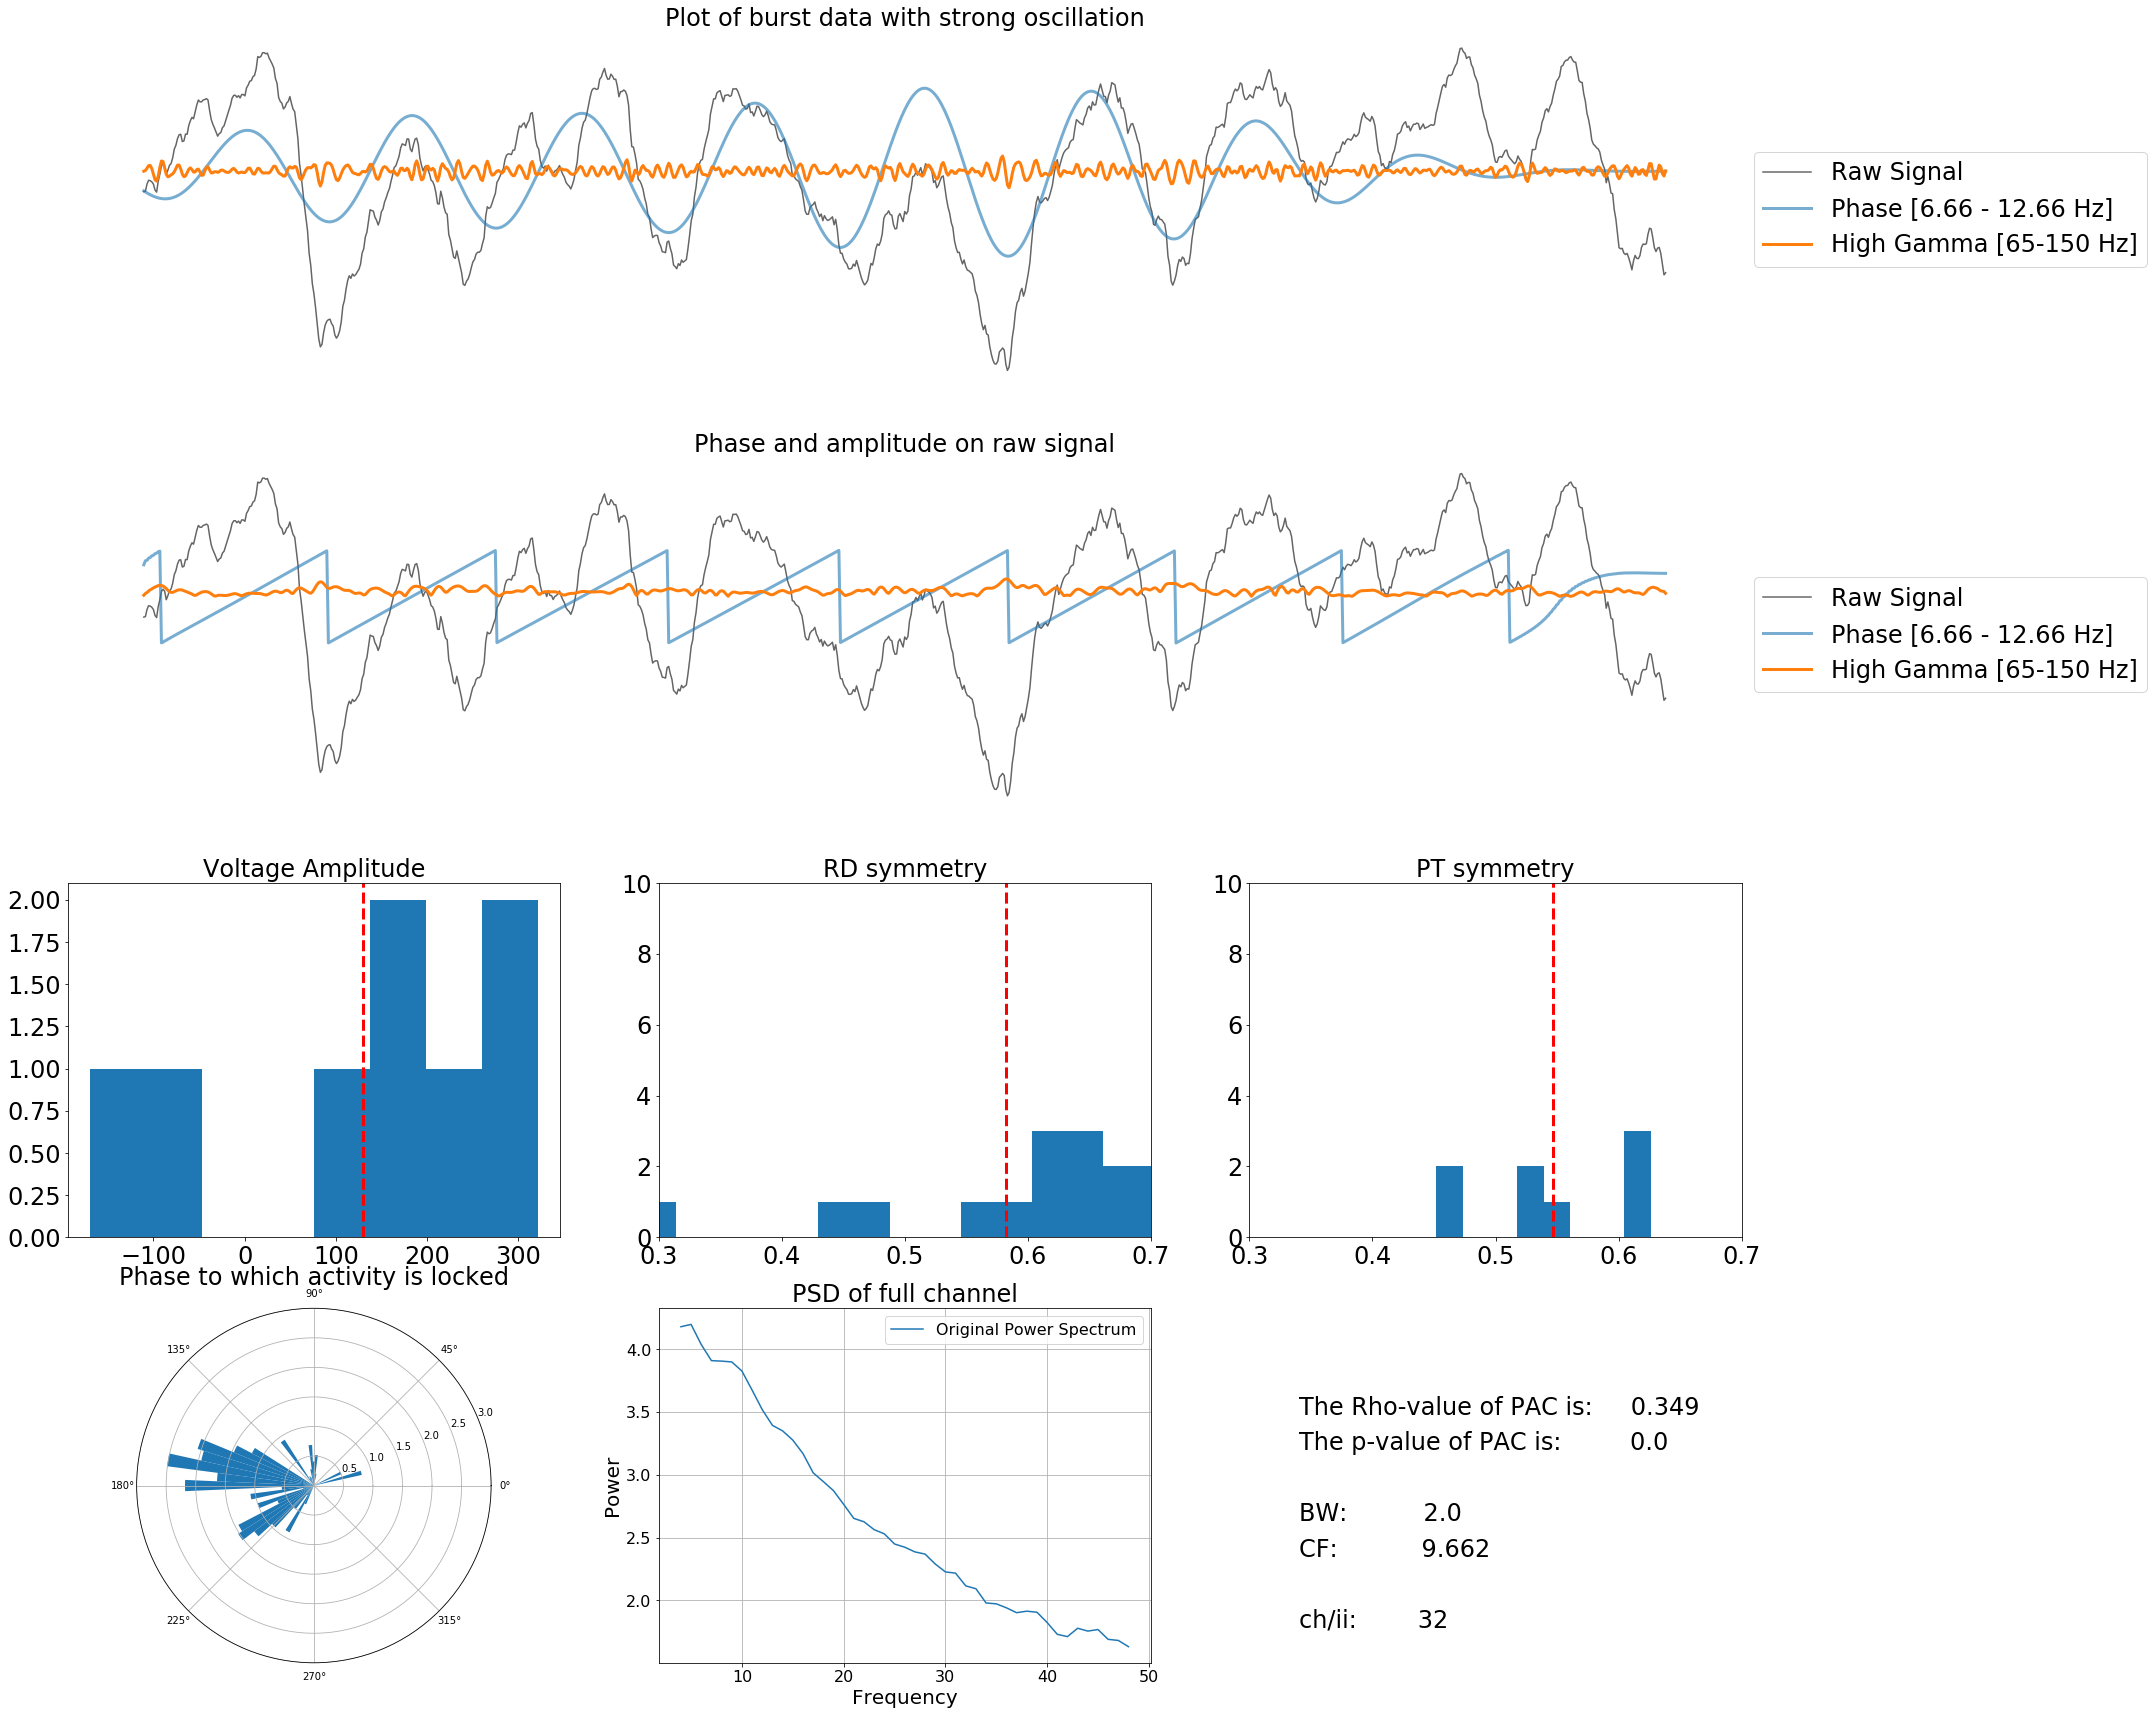

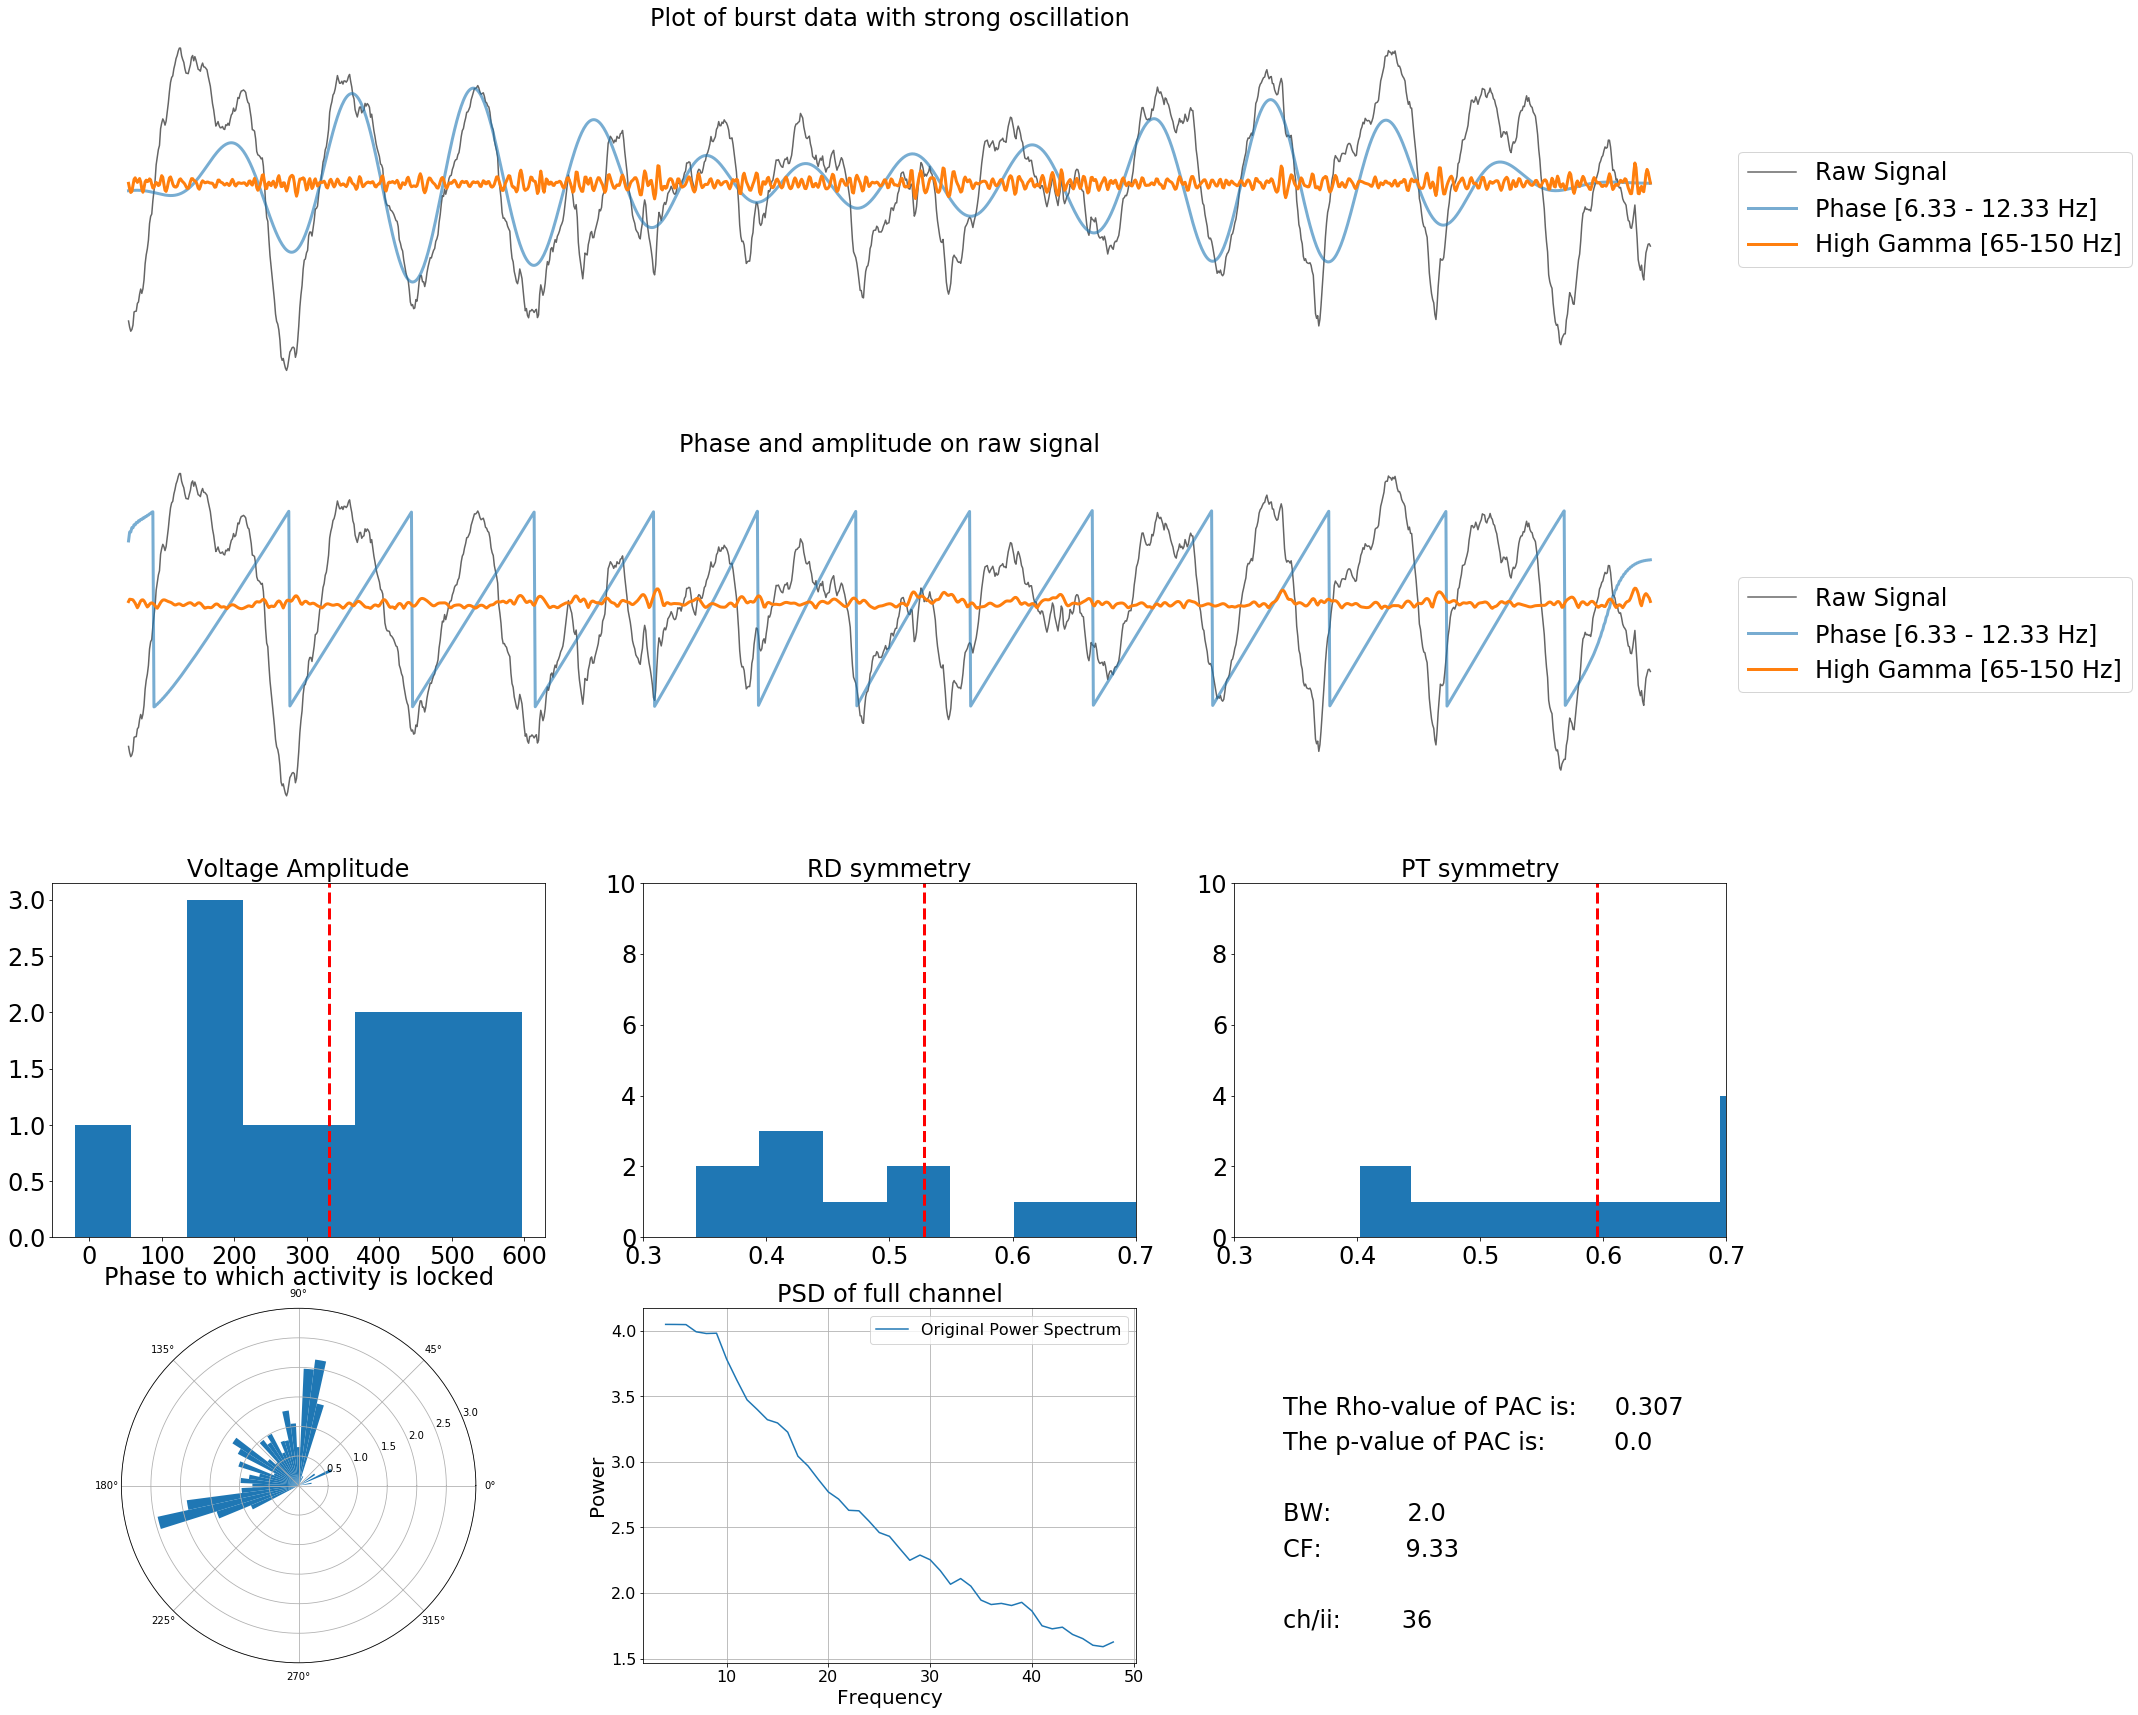

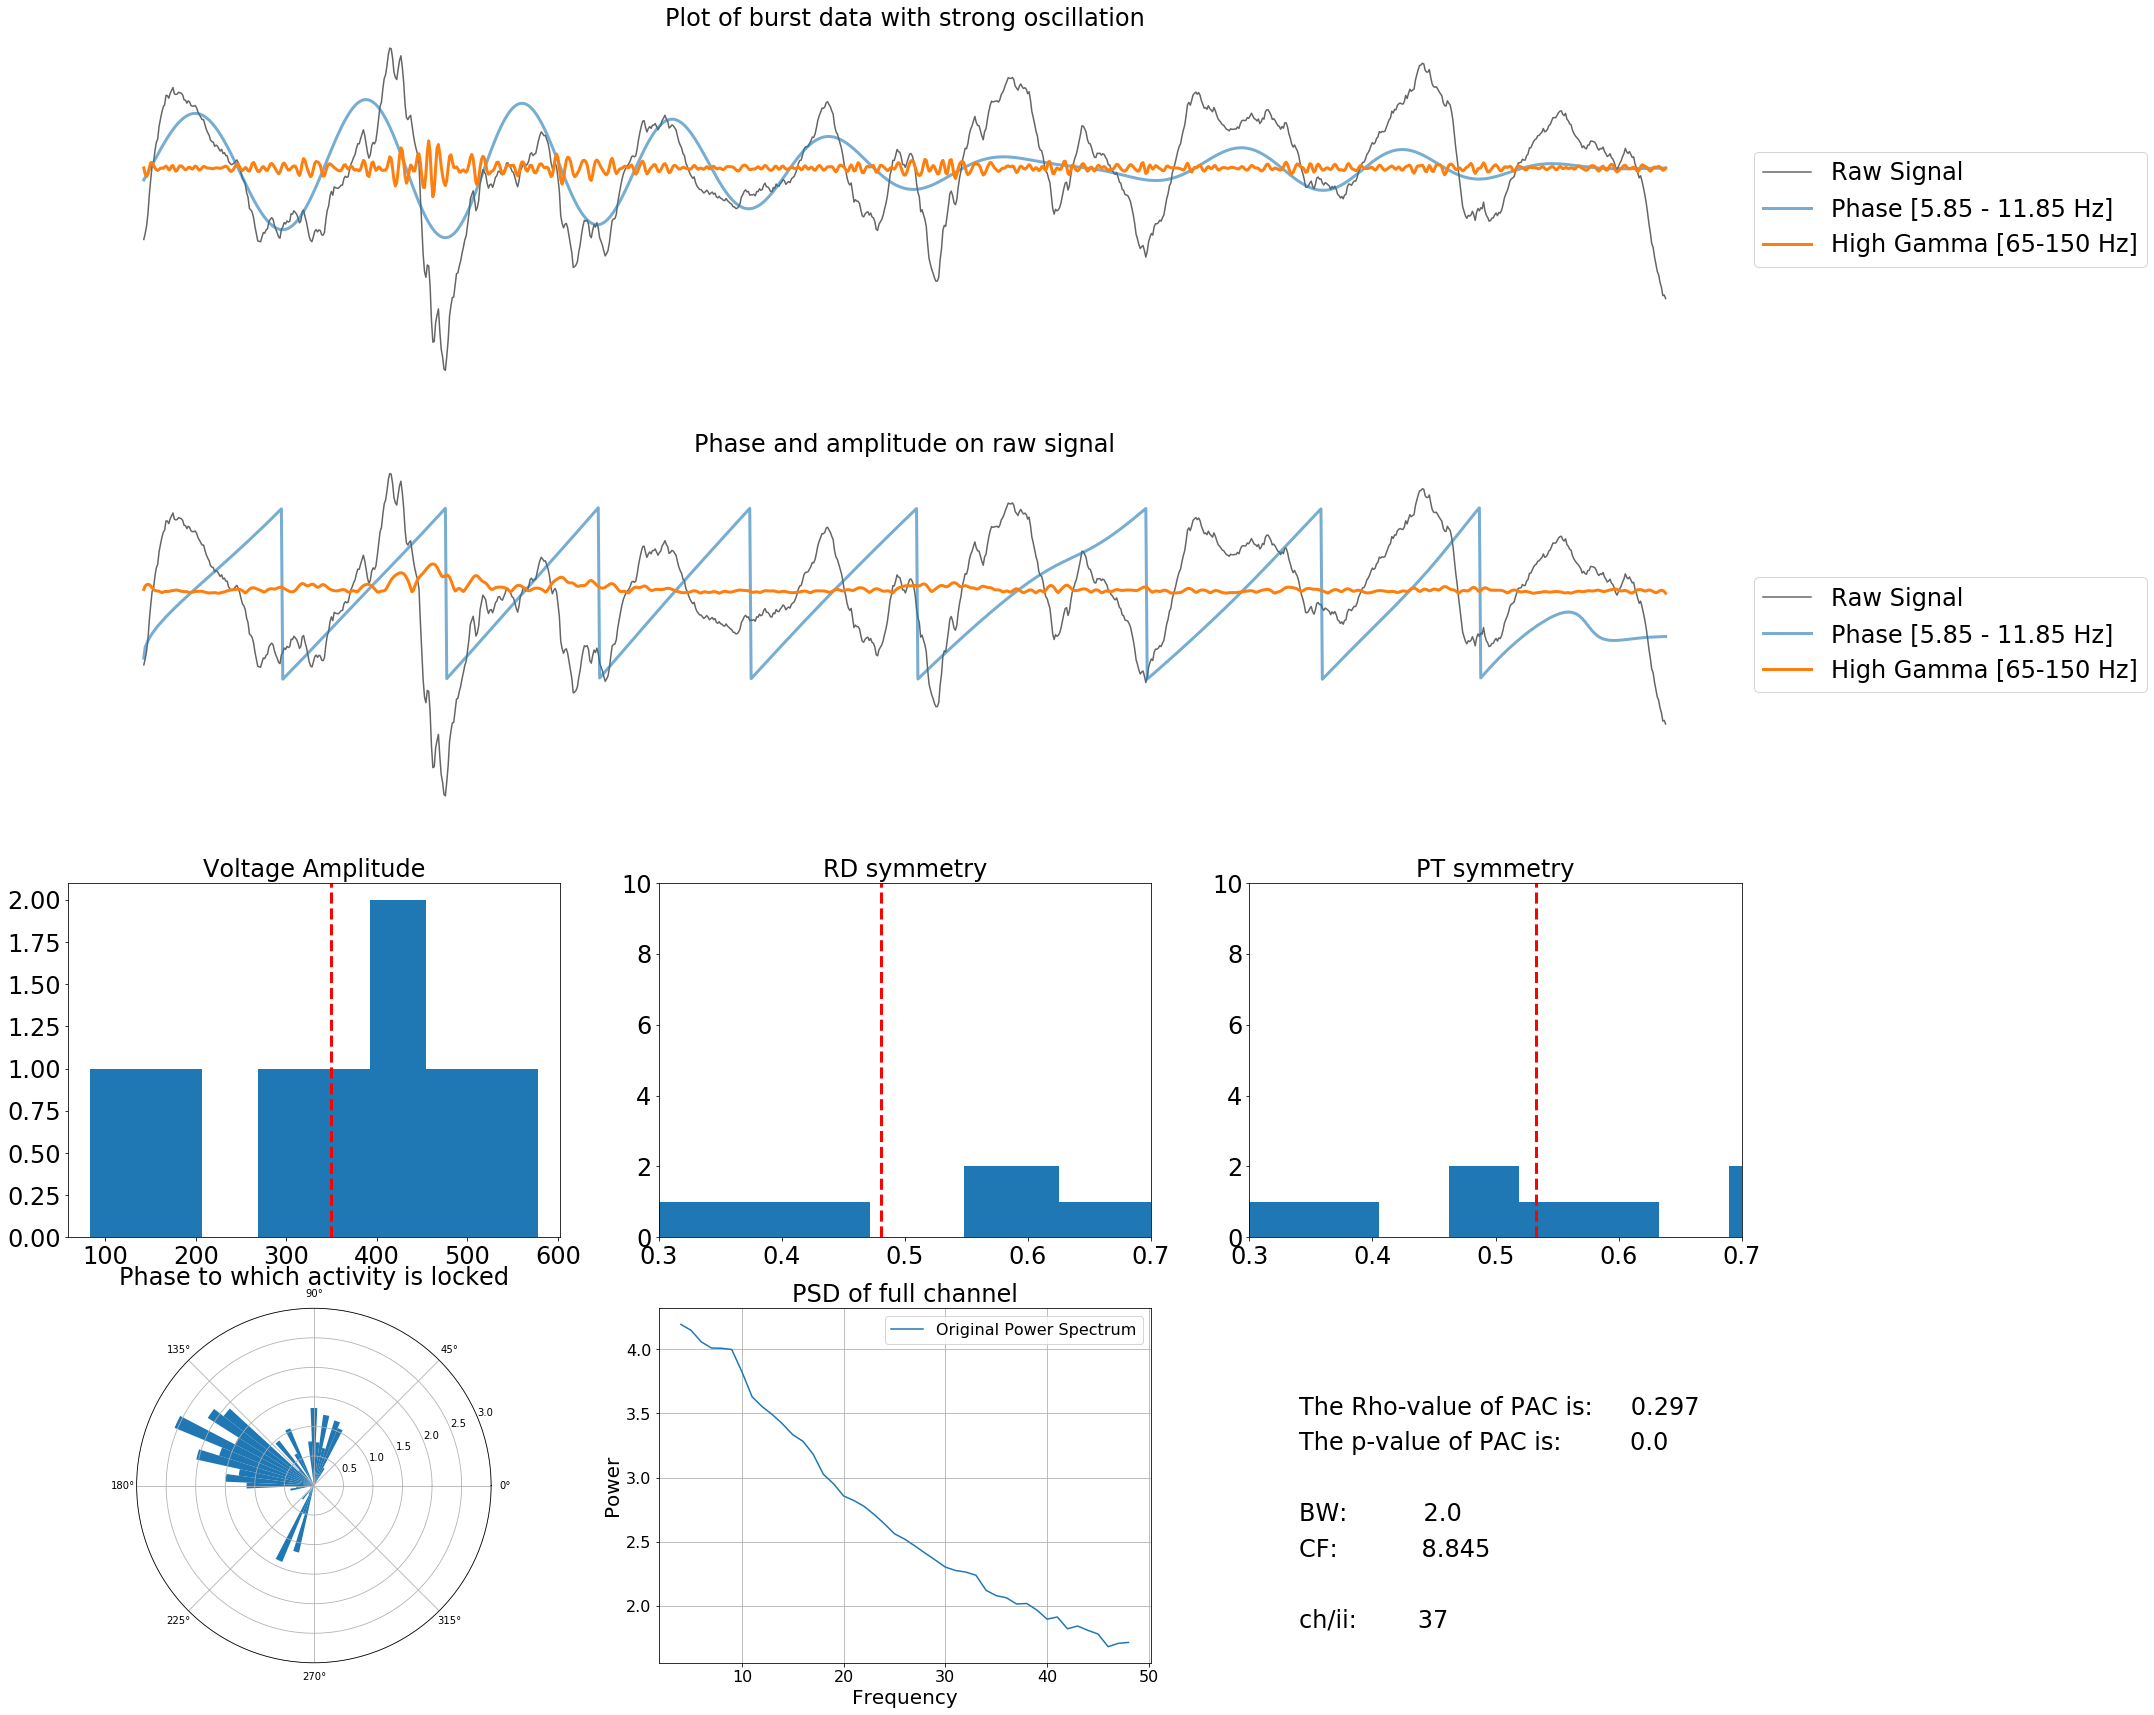

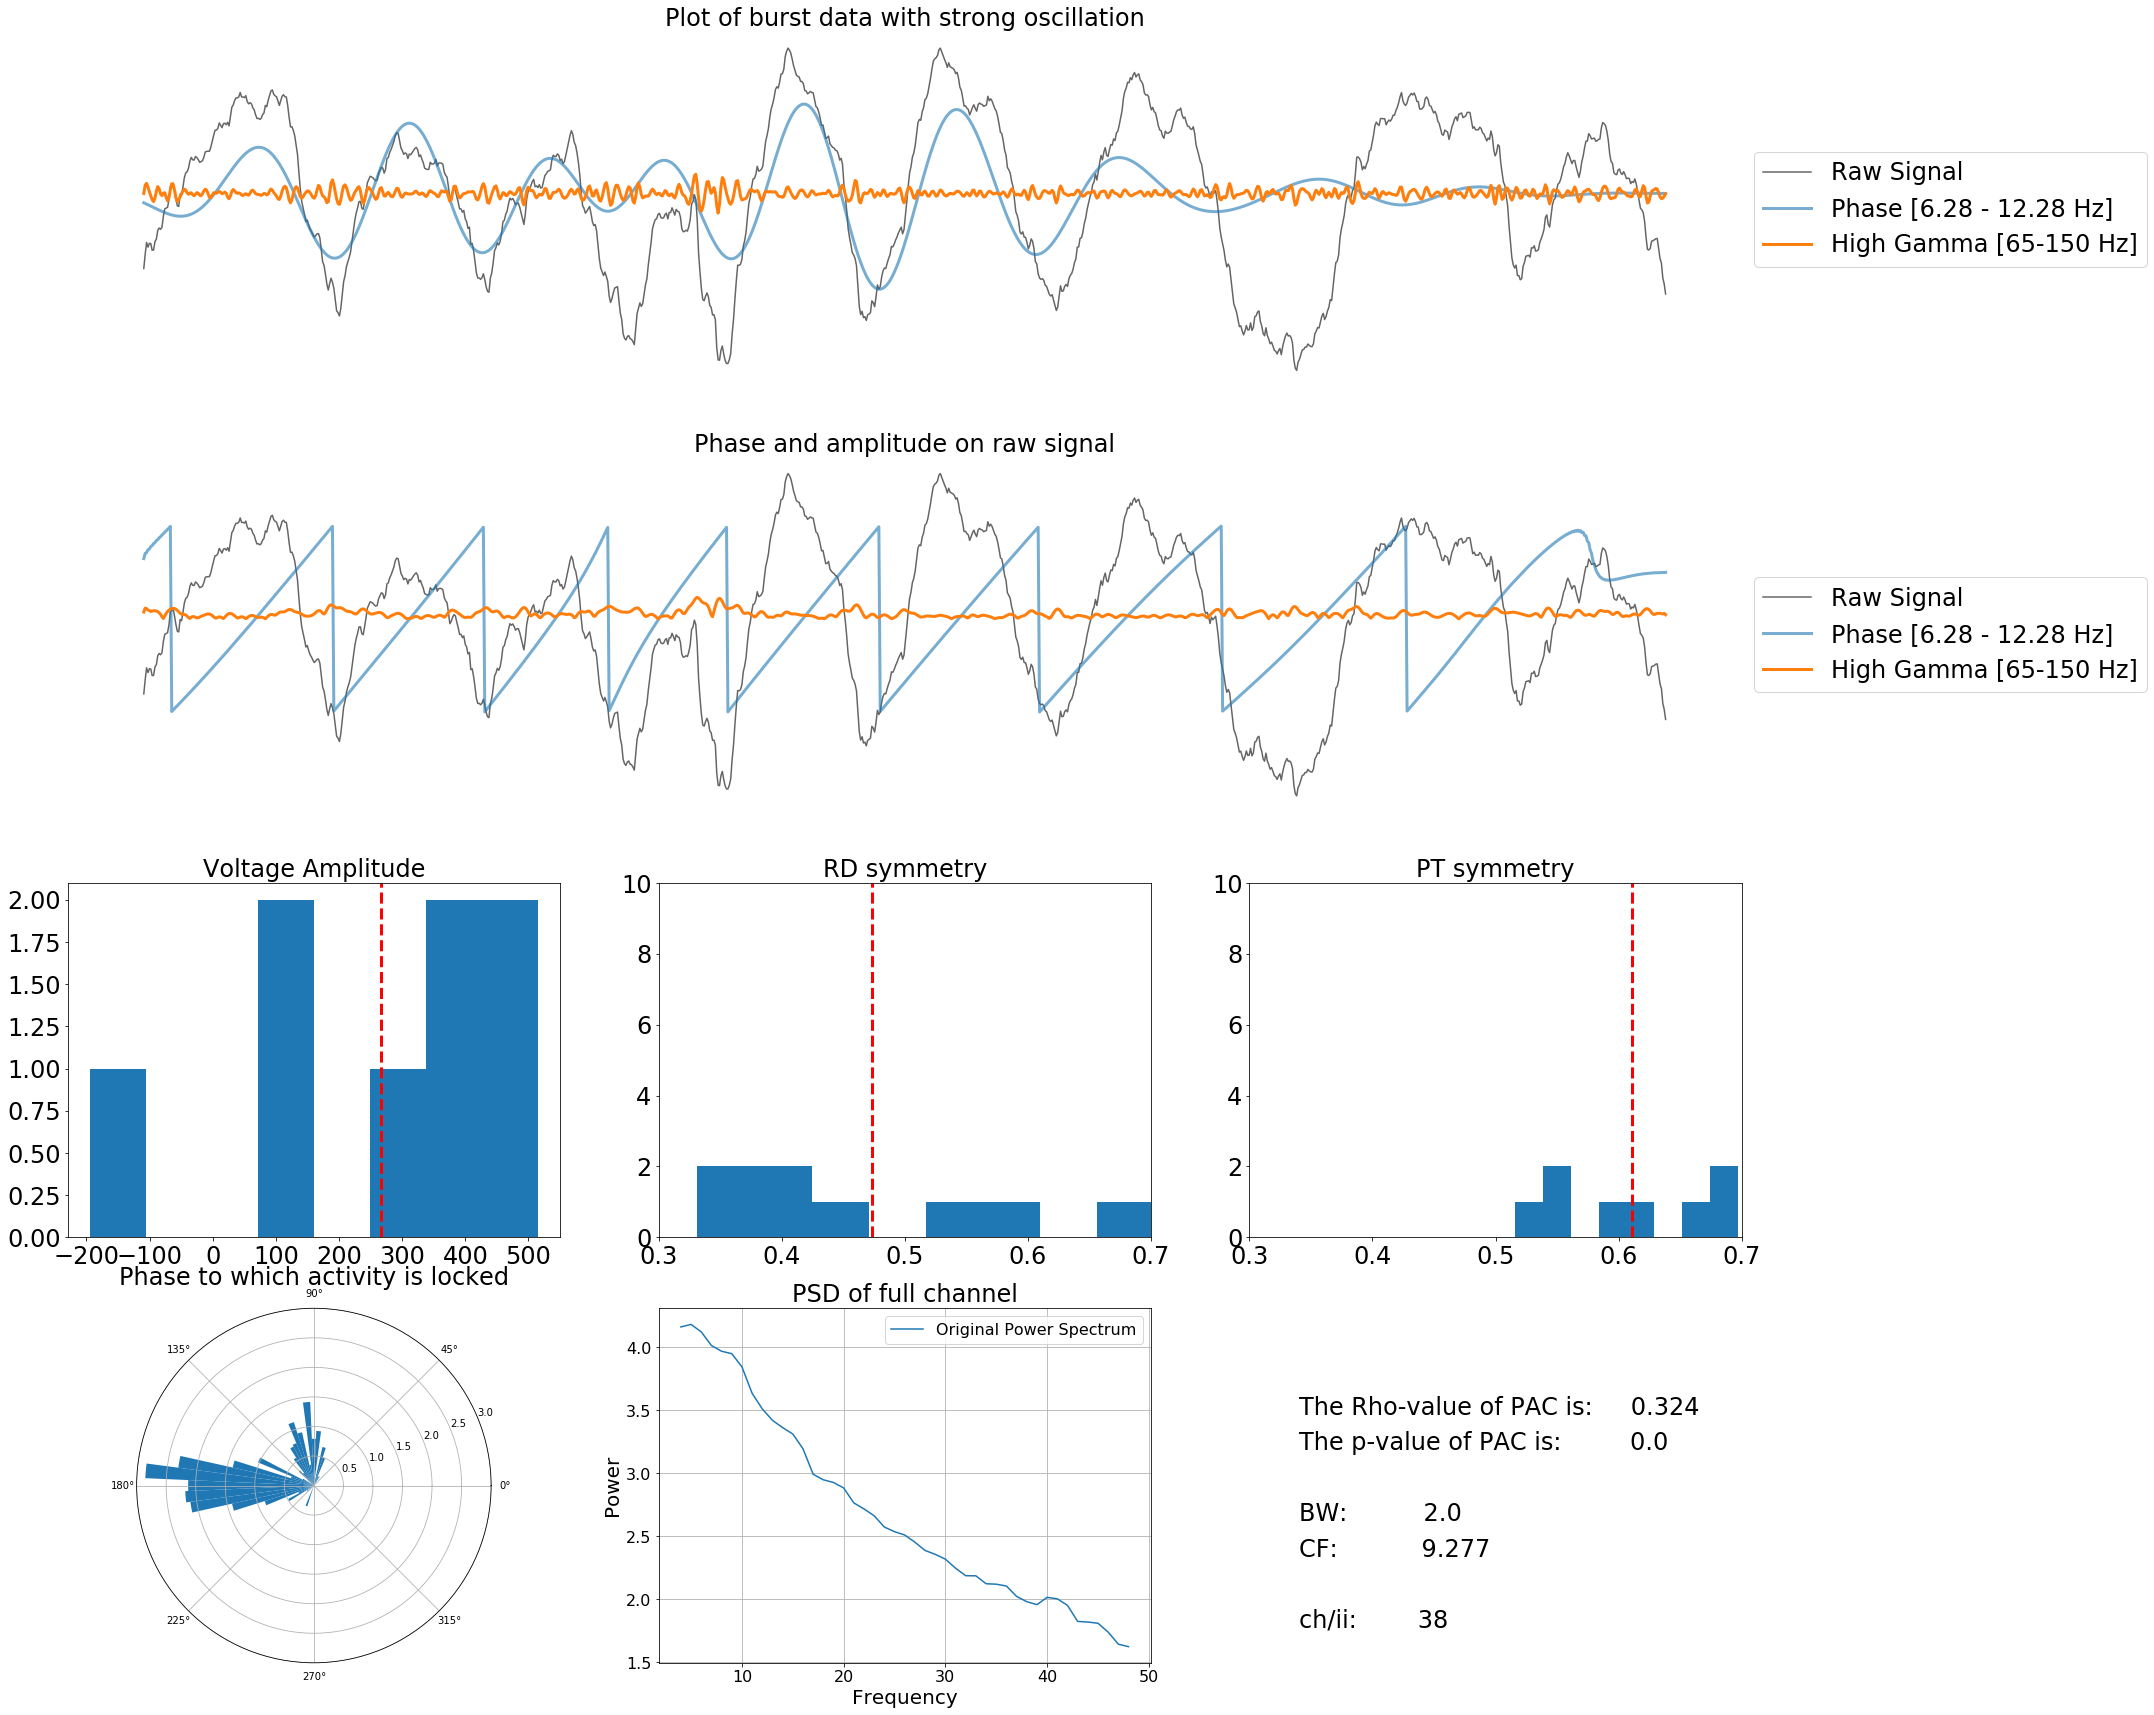

In [12]:
freq_range = [4, 48] # for peak detection
bw_lims = [2, 6]
max_n_peaks = 5

key = 'monkey'

# set range of the band 
amplitude_providing_band = [80, 250]

for ii in range(30,40):
    
    if type(burst_list[key][ii]) == list:
        
        if burst_list[key][ii][2]:

            # define phase providing band
            CF = features_df[key]['CF'][ii]
            BW = features_df[key]['BW'][ii]


            # phase_providing_band= [(CF - (BW/2)),  (CF + (BW/2))]
            phase_providing_band= [(CF - (BW/2))-1,  (CF + (BW/2))+1]

            start_sample = burst_list[key][ii][0]
            end_sample = burst_list[key][ii][1]

            signal, fs = get_signal(datastruct, features_df, key, ii) 
            signal = signal[start_sample:end_sample]
            # data = datastruct[subj][ch][ep][start_sample:end_sample]
            # data = datastruct[subj][day][ch][ep][start_sample:end_sample]

            # use butter bandpass filter to extract this frequency range
            phase_data = pacf.butter_bandpass_filter(signal, phase_providing_band[0], phase_providing_band[1], fs);
            phase_data_hilbert = hilbert(phase_data);
            phase_data_angle = np.angle(phase_data_hilbert);
            
            # use butter bandpass filter to extract this frequency range
            amp_data = pacf.butter_bandpass_filter(signal, amplitude_providing_band[0], amplitude_providing_band[1], fs);
            amp_data_hilbert = hilbert(amp_data);
            amp_data_abs = abs(amp_data_hilbert);
            

            # plot signal
            # plt.figure(figsize=(30,30))
            fig = plt.figure(figsize=(30,30))
            gs = fig.add_gridspec(4, 3)
            
            # ax1: signal plot
            f_ax1 = fig.add_subplot(gs[0, :])
            plt.plot(signal - np.mean(signal),label= 'Raw Signal', color='black', alpha=.6)
            plt.plot(phase_data,
                     label= 'Phase [{0:.2f} - {1:.2f} Hz]'.format(phase_providing_band[0]-1, phase_providing_band[1]+1),
                     linewidth=3, alpha=.6)
            plt.plot(amp_data,label= 'High Gamma [65-150 Hz]',
                     linewidth=3)
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=24)
            plt.title('Plot of burst data with strong oscillation', size=24)
            plt.axis('off')
            
            # ax2: phase and amplitude plot
            f_ax2 = fig.add_subplot(gs[1, :])
            plt.plot(signal - np.mean(signal),label= 'Raw Signal', color='black', alpha=.6)
            plt.plot((phase_data_angle*np.mean(burst_list[key][ii][2])/2),
                     label= 'Phase [{0:.2f} - {1:.2f} Hz]'.format(phase_providing_band[0]-1, phase_providing_band[1]+1),
                     linewidth=3, alpha=.6)
            plt.plot(amp_data_abs,label= 'High Gamma [65-150 Hz]',
                     linewidth=3)
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=24)
            plt.title('Phase and amplitude on raw signal', size=24)
            plt.axis('off')
            
            # ax3: Amplitude distribution
            f_ax3 = fig.add_subplot(gs[2,0])
            plt.hist(burst_list[key][ii][2], bins=8)
            plt.axvline(np.mean(burst_list[key][ii][2]), color='red', linestyle='dashed', linewidth=3)
            plt.title('Voltage Amplitude', size=24)
            plt.xticks(fontsize=24)
            plt.yticks(fontsize=24)

           
            # ax4: RD Symmetry
            f_ax4 = fig.add_subplot(gs[2,1])
            plt.hist(burst_list[key][ii][3],bins=8)
            plt.axvline(np.mean(burst_list[key][ii][3]), color='red', linestyle='dashed', linewidth=3)
            plt.title('RD symmetry', size=24)
            plt.xticks(np.arange(0.3, 0.8, step=0.1), fontsize=24)
            plt.yticks(fontsize=24)
            plt.xlim((0.3,0.7))
            plt.ylim(0,10)
            
            
            # ax5: PT Symmetry
            f_ax5 = fig.add_subplot(gs[2,2])
            plt.hist(burst_list[key][ii][4], bins=8)
            plt.axvline(np.mean(burst_list[key][ii][4]), color='red', linestyle='dashed', linewidth=3)
            plt.title('PT symmetry', size=24)
            plt.xticks(np.arange(0.3, 0.8, step=0.1), fontsize=24)
            plt.yticks(fontsize=24)
            plt.xlim((0.3,0.7))
            plt.ylim(0,10)
            #plt.show()
            
            
            # preprocessing circle plot
            bin_size = 5; 
            bins = range(-180,180+bin_size,bin_size); 
            bins = np.dot(bins, 0.0174532925);

            amps = [];

            #filling phase bins with amplitudes
            for x in range(len(bins)-1):
                # find the lower bound of the bin
                amps_above_lo_bound = np.where(phase_data_angle >= bins[x])[0];
                # find the higher bound of the bin
                amps_below_hi_bound = np.where(phase_data_angle < bins[x+1])[0];
                amps_below_hi_bound = set(amps_below_hi_bound);
                # select all samples that are within the range
                amp_inds_in_this_bin = [amp_val for amp_val in amps_above_lo_bound if amp_val in amps_below_hi_bound]
                # find corresponding amplitudes for these samples
                amps_in_this_bin = amp_data_abs[amp_inds_in_this_bin];
                # calculate mean
                amps.append(np.mean(amps_in_this_bin));

            bins = bins[:len(bins)-1];

            #normalizing to make the effect more clear
            amps = (amps-np.mean(amps))/np.std(amps);

            
            # ax6: Circle correlation
            f_ax6 = fig.add_subplot(gs[3,0], projection='polar')
            plt.bar(bins, amps, width=bins[1]-bins[0], bottom=0.0)
            plt.ylim([0,3])
            plt.title('Phase to which activity is locked', size=24);
            

            #calculate circle correlation
            rho, pval, r_2, standard_error = pacf.circle_corr(phase_data_angle, amp_data_abs)
            
            # use full data for PSD
            signal, fs = get_signal(datastruct, features_df, key, ii) 
            
            # compute frequency spectrum
            freq_mean, psd_mean = spectral.compute_spectrum(signal, fs, method='welch', avg_type='mean', nperseg=fs)
            # Initialize FOOOF model
            fm = FOOOF(peak_width_limits=bw_lims, background_mode='knee', max_n_peaks=max_n_peaks)
            # fit model
            fm.fit(freq_mean, psd_mean, freq_range) 

            # ax7: Circle correlation
            f_ax7 = fig.add_subplot(gs[3,1])
            plot_spectrum(fm.freqs, fm.power_spectrum, label='Original Power Spectrum', ax=f_ax7)
            plt.title('PSD of full channel', size=24)
            
            
            # ax8: Stats 
            f_ax8 = fig.add_subplot(gs[3,2])
            f_ax8.text(1,7, 'The Rho-value of PAC is:' + '     ' + str(round(rho,3)), fontsize=24)
            f_ax8.text(1,6, 'The p-value of PAC is:' + '         ' + str(round(pval,3)), fontsize=24)
            f_ax8.text(1,4, 'BW:          ' +  str(round(BW,3)), fontsize=24) 
            f_ax8.text(1,3, 'CF:           '  + str(round(CF,3)), fontsize=24) 
            f_ax8.text(1,1, 'ch/ii:        '  + str(ii), fontsize=24)
                       
            f_ax8.axis([0, 10, 0, 10])
        
            f_ax8.axis('off')
            plt.show()

# 10. Spatial consistency of measured features (for discussion)

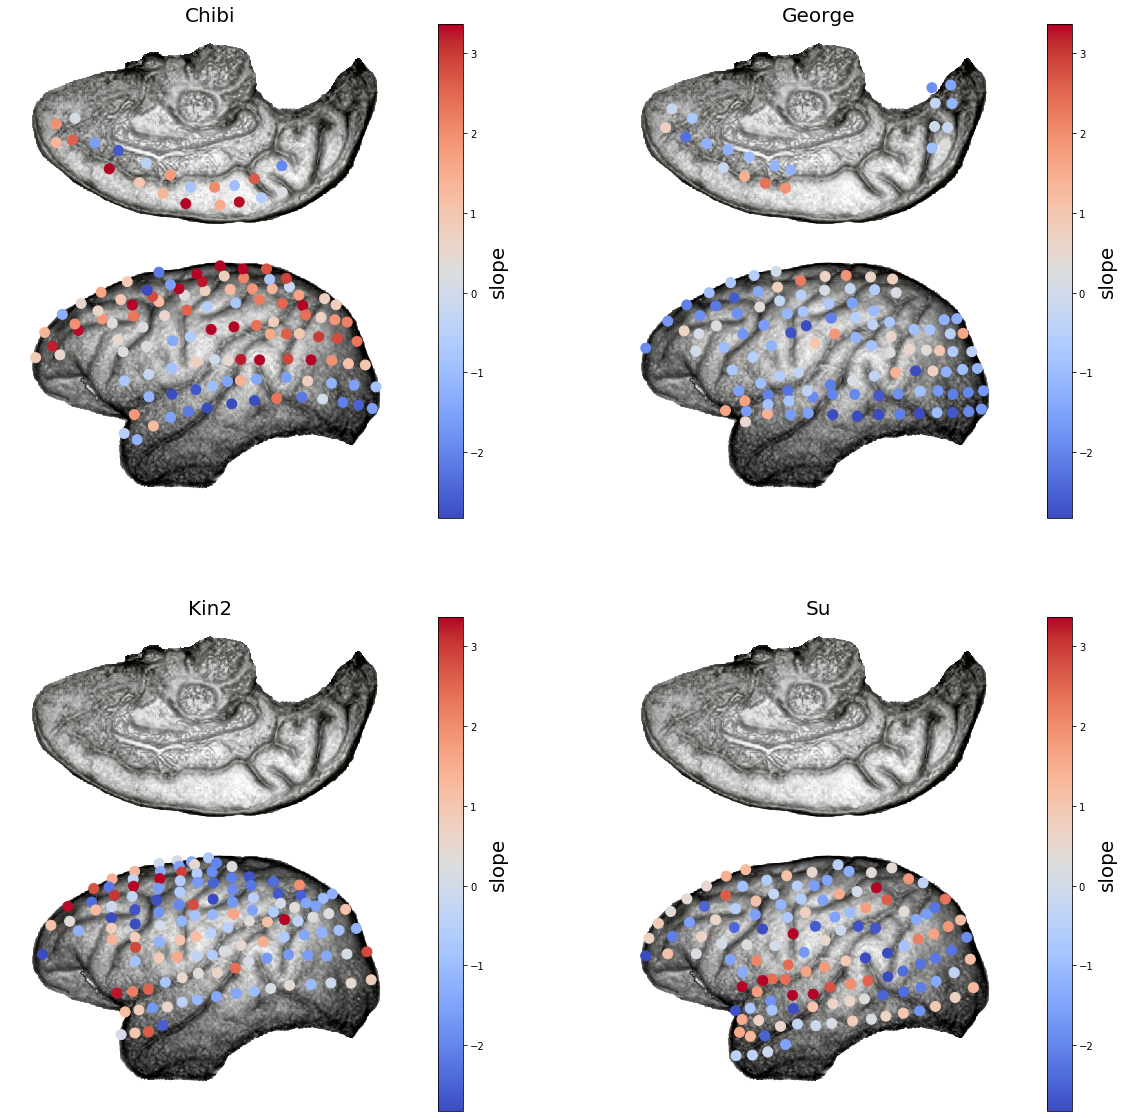

In [13]:
subjects = ['Chibi', 'George', 'Kin2', 'Su']
var = 'slope'

# set vmin and vmax as quantiles to deal with outliers and make consistent labeling
vmin = features_df['monkey'][var].quantile(0.05)
vmax = features_df['monkey'][var].quantile(0.95)

plt.figure(figsize=(20,20))
for subj in range(len(subjects)):  
    # go to specific map
    os.chdir(r'C:\Users\jaapv\Desktop\master\VoytekLab\neurotycho\anesthesia_sleep_task')    
    filemap = os.path.join(os.getcwd(), subjects[subj])   
    os.chdir(filemap)
    filename = glob.glob("*Map.mat")
    spatial_map = sio.loadmat(filename[0])

    var_values = [
            features_df['monkey'][(features_df['monkey']['subj'] == subj) & (features_df['monkey']['ch'] == ch)][var].median() 
            for ch in range(len(spatial_map['X']))
                ] 

    var_values = np.reshape(var_values, [len(var_values), 1]) 

    plt.subplot(2,2,subj+1)
    plt.imshow(spatial_map['I'])
    plt.scatter(spatial_map['X'], spatial_map['Y'], s=100, c=var_values, cmap='coolwarm',
                vmin=vmin, vmax=vmax)
    plt.title(subjects[subj], size=20)
    plt.axis('off')
    cbar= plt.colorbar()
    cbar.set_label(var, size=20)